<font color=darkblue> 
Jupyter Notebook to go with 
    
**Model mis-specification and bias in least squares:  Implications for linearized isotropic AVO** 
    
Henning Hoeber, CGG, October 2021, The Leading Edge.    

Code and worksheet come without any warranty.

*   References can be found in the paper.
*   Figure and equation numbers refer back to the paper. I create some extra plots in this notebook.
*  Inputs: 
    * either a csv file with the Zoeppritz input parameters or just change the 6 Zoeppritz values in the cell.
*  Parameters (other than input model) you may wish to change:
    * angle range for the modeling or fitting
    * display AVO fits as a function of angle (default) or ${\sf sin}^2(\theta)$.   
    * The noise variance for the Monte Carlo modeling
    
Note: figure 3 is not reproduced here, but can be obtained by looping over the part of the code that calculates bias.


### Modeling parameters from csv file:

In [23]:
import pandas as pd
inputFile = 'inputsAVOZoeppritz.csv'
df = pd.read_csv (inputFile)
print('Parameters read from', inputFile)
df

Parameters read from inputsAVOZoeppritz.csv


vp      vs     density
0  2500    1100        2.35
1  2880    1810        1.99

In [24]:
vp1 = df.iloc[0,0]
vp2 = df.iloc[1,0]
vs1 = df.iloc[0,1]
vs2 = df.iloc[1,1]
rho1 = df.iloc[0,2]
rho2 = df.iloc[1,2]

***Or just change the parameters here!***

The paper is using a class 3 AVO model:

In [25]:
vp1=2500
vp2=2880
vs1=1100
vs2=1810
rho1=2.35
rho2=1.99

In [26]:
def printZoeppritzModel(vp1, vp2, vs1, vs2, rho1, rho2):
    print('*********************** Zoeppritz model  ***************************')
    print('vp1 = %.2f' % vp1, 'vs1 = %.2f' % vs1, 'rho1 = %.4f' % rho1)
    print('vp2 = %.2f' % vp2, 'vs2 = %.2f' % vs2, 'rho2 = %.4f' % rho2)
    print('********************************************************************')

In [27]:
printZoeppritzModel(vp1, vp2, vs1, vs2, rho1, rho2)

*********************** Zoeppritz model  ***************************
vp1 = 2500.00 vs1 = 1100.00 rho1 = 2.3500
vp2 = 2880.00 vs2 = 1810.00 rho2 = 1.9900
********************************************************************


In [28]:
# Libraries and plotting defaults
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import math
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 350
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth']=2.5
plt.rcParams['lines.markersize']=8
# Default sizes for figure labels
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['figure.titlesize'] = 25
plt.rcParams['legend.fontsize'] = 22
plt.rc('font',family='monospace')
# fontsize for annotations
fsann=30
# unicode density and gamma
import sys
rho = '\u03C1'
gammauni = '\u03B3'
#print (rho)
#print(gammauni)

## AVO models to lowest order: Aki-Richards, Shuey, Fatti

<font color=darkblue> 
We start with the linearised, and hence small reflectivity, AVO equation due to Aki and Richards [Aki & Richards]:
    
$$
R_{\sf AR}(\theta) =  \left\{ 1 + {\sf tan}^2(\theta) \right\}
{dv_P \over 2 v_P} - 8 {v_S^2 \over v_P^2} {\sf sin}^2(\theta)
{d v_S \over 2 v_S} 
+ \left\{ 1 - 4 {v_S^2 \over v_P^2} {\sf sin}^2(\theta \right\} {d \rho \over 2 \rho} 
\, \, 
$$
    
I will then use two variations of this equation, see the paper for references. 
First, the equations are re-arranged in order of importance with angle:
    
$$
R_{\sf Shuey}(\theta) =  
\left\{{d \rho \over 2 \rho}+ {dv_P \over 2 v_P} \right\}
+
\left\{ {dv_P \over 2 v_P} - 4 {v_S^2 \over v_P^2} \left(
2 {dv_S \over 2 v_S} + {d \rho \over 2 \rho}
\right) \right\} 
{\sf sin}^2(\theta)
+
{d v_P \over 2 v_P}{\sf sin}^2(\theta){\sf tan}^2(\theta)
$$   

Secondly, the equations are written in terms of the impedance contrasts 
    
$$
R_{\sf Fatti}(\theta) =  \left\{ 1 + {\sf tan}^2(\theta) \right\}
{dI_P \over 2 I_P} - 8 {v_S^2 \over v_P^2} {\sf sin}^2(\theta)
{d I_S \over 2 I_S} 
- \left\{{\sf tan}^2(\theta) - 4 {v_S^2 \over v_P^2} {\sf sin}^2(\theta) \right\} {d \rho \over 2 \rho} 
\, \, 
$$
    
I will call this the Fatti approximation.
    
The Shuey and Fatti models have the same $R_{I_S}$ dependency. Mismatch of a two-term Shuey model to Aki-Richards is largest for significant values of $R_{v_P}$, whereas for Fatti, the two-term version becomes error-prone with large density contrasts.
    
Notice how the three-term Aki-Richards and Fatti models have different density terms; if we drop the density term in both models, something odd happens when we fit the data and compare Aki-Richards to Fatti. The two lowest order parameter estimates of both models in least-squares will be identical, but the forward models interpret the parameters differently. They cannot both be correct; how the AVO model is linearised and truncated clearly matters.

The Shuey parameterisation is more often written using the three reflectivity shortcuts
$$
R(0) = \left\{ {dv_P \over 2 v_P} + {d\rho \over 2 \rho} \right\} = R_{v_P}+ R_{\rho} 
= R_{I_P}
$$
$$
G = {1 \over 2} {dv_P \over v_P} - 2 \gamma^2 \left\{ {d\rho \over \rho} + 2 {dv_S \over v_S} \right\}  = 
R_{v_P}- 4 \gamma^2 \left( 2 R_{v_S} + R_{\rho} \right) = R_{I_P} - 8 \gamma^2 R_{I_S} + R_{\rho}(4 \gamma^2 - 1)
$$
$$
C = {1 \over 2} {dv_P \over v_P} = R_{v_P} = R_{I_P} - R_{\rho}
$$
where 
$$ \gamma =  v_S/v_P \, . $$
$$
dx = x_2 - x_1 = x_{\sf lower} - x_{\sf upper}  
$$
$$
x = {x_2 + x_1 \over 2} = {x_{\sf lower} + x_{\sf upper} \over 2} \, .
$$
For $v_P$, $v_S$ and $\rho$ we use:
$$ R_x = {dx \over 2x} \, .$$ 
For the Shuey and Fatti parameterisations to be identical and equal the Aki-Richards 
model with three terms we use the weak reflectivity approximations
$$R_{I_P} = R_{v_P} + R_{\rho}$$
and
$$R_{I_S} = R_{v_S} + R_{\rho}\, .$$
This rule should also be followed when other AVO parameters are used to build new AVO models at lowest order if we want them to be numerically comparable: track every parameter back to the velocity and density first, rather than using the $R_x = {dx \over 2x}$ formula directly. Keep in mind that all these relations are only exact in the weak reflectivity approximation.
    
The above AVO formulations, in terms of velocity and impedances, still hide the underlying physics. We will need to relate changes in more physical quantities, such as porosity, fluids and pressure to the parameters in the AVO equations. This is not done here.
</font>

## Pseudo-quadratic AVO model due to Mallick and Wang

<font color=darkblue> 
    When working only to lowest order, 
the contrasts of all elastic parameters are assumed small relative to their averages across the boundary. Wang [1999] and Mallick [1993] showed that at next highest order we have
$$
R_{\sf Wang-Mallick}(\theta_{\sf av}) = R_{\sf AR}(\theta_{\sf av}) +  \gamma^3 \sin^2(\theta_{\sf av})  \cos(\theta_{\sf av}) 
\left\{ 
{d\rho \over \rho} + 2 {dv_S \over v_S} 
\right\}^2   \, .
$$
The difference between the Aki-Richards and the Wang-Mallick is largest as a function of $R_{v_s}$.
    
I find this correction to be required more often than not, with AVO models in published papers. It may not be sufficient, but in my experience often provides the bulk of the higher order correction.
        
Using 
$$
C-G = 2 \gamma^2 ({d\rho \over \rho} + 2 {dv_S \over v_S} )
$$
we may write:
$$
R_{\sf Wang-Mallick}(\theta_{\sf av}) = R(0) + G \, \sin^2(\theta_{\sf av}) + C \, \sin^2(\theta_{\sf av}) \tan^2(\theta_{\sf av})  +  \sin^2(\theta_{\sf av})  \cos(\theta_{\sf av}) (C-G)^2 {1 \over 4 \gamma} \, .
$$
Omitting the third term sets the curvature, or the P-wave contrast to zero. Omitting the quadratic term can similarly be viewed 
as choosing a large $\gamma$ value. We will see this behaviour in action later on.
</font>

## Libraries and Code for AVO modeling 
Note: This notebook uses the bruges source-code for the full Zoeppritz calculation (but only this model), where I have copied that part of the code I need to keep this notebook self contained. Thanks to Agile for making this available. Any errors are mine. There is no warranty on this code.

In [29]:
#### Code copied from Agile bruges code, the code comes with no warranty!
### This version calculates just a single interface solution
###
### Reference: Bruges (2021). Bruges Python package, by the Bruges contributors. https://github.com/agile-geoscience/bruges 

def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns:
        The complex Zoeppritz solution for P-P reflectivity at the
            interface. 
    """
    theta1 = np.radians(theta1).astype(complex)

    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)

## AVO angles

In [30]:
# Angles (regressor X)
minangle = 0
maxangle = 35
nangle   = maxangle - minangle + 1
# X = the regressor 
Angles = np.linspace(minangle, maxangle, nangle)
# The incidence angle
theta1  = np.radians(Angles)
nobs = len(Angles) # number of observations
theta2 = np.arcsin(vp2/vp1*np.sin(theta1))
# Shuey is modelled with average angle, we need this in building the design matrix A later
avtheta = (theta1+theta2)/2.0
# The average angle is where the stack "lives"
stackangle = np.mean(np.sin(avtheta)*np.sin(avtheta))

<font color=red> 
**User choice: plot the AVO as a function of incidence angle.**
 </font>  

In [31]:
# In the figures, plot the incidence angle on the x-axis
Xplot  = Angles
xlabel = 'incidence angle (degrees)'

***Create various AVO models***

In [32]:
# Create Zoeppritz model using Bruges code
RZoeppritz =zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, Angles)
Y_Zoepp = RZoeppritz.real

In [33]:
# Layer to reflectivity conversion
# x1 is upper layer x2 is lower layer
def Rx(x1, x2):
    x  =0.5*(x1+x2)
    dx = x2-x1  # lower - upper
    Rx = 0.5* dx/x
    return Rx
gamma = (vs1+vs2)/(vp1+vp2)
Rvp = Rx(vp1, vp2)
Rvs = Rx(vs1, vs2)
Rd  = Rx(rho1, rho2)
# Note: you have to build RIp and RIs like this, otherwise the first order approximation
# may be voilated!
RIp = Rvp + Rd
RIs = Rvs + Rd
###########################
## Linearised Aki-Richards with three terms in the original formulation
p = np.sin(theta1)/vp1
vs = 0.5*(vs1+vs2)
Y_trueAR = (1 - 4 * p**2 * vs**2)* Rd + (1/(2*np.cos(avtheta)**2)) *2 *Rvp - 8*p**2 * vs**2 * Rvs
#
# Shuey reflectivity shortcuts intercept R(0), gradient G and curvature C (third term)
R0 = Rvp + Rd
G  = Rvp - 4 * gamma**2 * (Rd + 2*Rvs)
C  = Rvp  
#
Rvsd = Rd + 2 * Rvs

In [34]:
def avoAK2T(avtheta, R0, G):
    Y_ARShuey2T = R0 + G*np.sin(avtheta)**2 
    return Y_ARShuey2T  
def avoAK3T(avtheta, R0, G, C):
    Y_ARShuey3T = R0 + G*np.sin(avtheta)**2  + C * np.sin(avtheta)**2 * np.tan(avtheta)**2 
    return Y_ARShuey3T   
def avoAK4T(avtheta, R0, G, C):
    term4 = (1/(4*gamma)) * (C-G)**2 * (np.sin(avtheta))**2 * (np.cos(avtheta)) 
    Y_ARShuey4T = avoAK3T(avtheta, R0, G, C) + term4
    return Y_ARShuey4T   
def avoFatti2T(avtheta, RIp, RIs, Rd):
    g2 = gamma**2 
    XX0F  = 1 + (np.tan(avtheta))**2
    XX1F  = -8*g2*(np.sin(avtheta))**2
    Y_Fatti2T = RIp* XX0F + RIs * XX1F
    return Y_Fatti2T
# Fatti 3T is the same as AR 3T 
def avoFatti3T(avtheta, RIp, RIs, Rd):
    Y_Fatti2T = avoFatti2T(avtheta, RIp, RIs, Rd) 
    XX2F = -(np.tan(avtheta))**2 +  4 * gamma**2 *(np.sin(avtheta))**2
    Y_Fatti3T = Y_Fatti2T + Rd * XX2F
    return Y_Fatti3T
################################################
Y_ARShuey2T = avoAK2T(avtheta, R0, G)
Y_ARShuey3T = avoAK3T(avtheta, R0, G, C)
Y_ARShuey4T = avoAK4T(avtheta, R0, G, C)
Y_Fatti2T   = avoFatti2T(avtheta, RIp, RIs, Rd)
Y_Fatti3T   = avoFatti3T(avtheta, RIp, RIs, Rd)

## Figure 1 left:
Plot different AVO models

Note: in some cases you may wish to offset Xplot $\longrightarrow$ Xplot + 0.2, eg when Zoeppritz and Wang-Mallick are in good agreement the curves will overlay.

maxangle 35
max average angle 38.17893233449576
*********************** Zoeppritz model  ***************************
vp1 = 2500.00 vs1 = 1100.00 rho1 = 2.3500
vp2 = 2880.00 vs2 = 1810.00 rho2 = 1.9900
********************************************************************
3-term model params for Aki Richards are
R(0) = -0.012317
G = -0.403349
C = 0.070632
Rd = -0.082949
R0-C = -0.082949


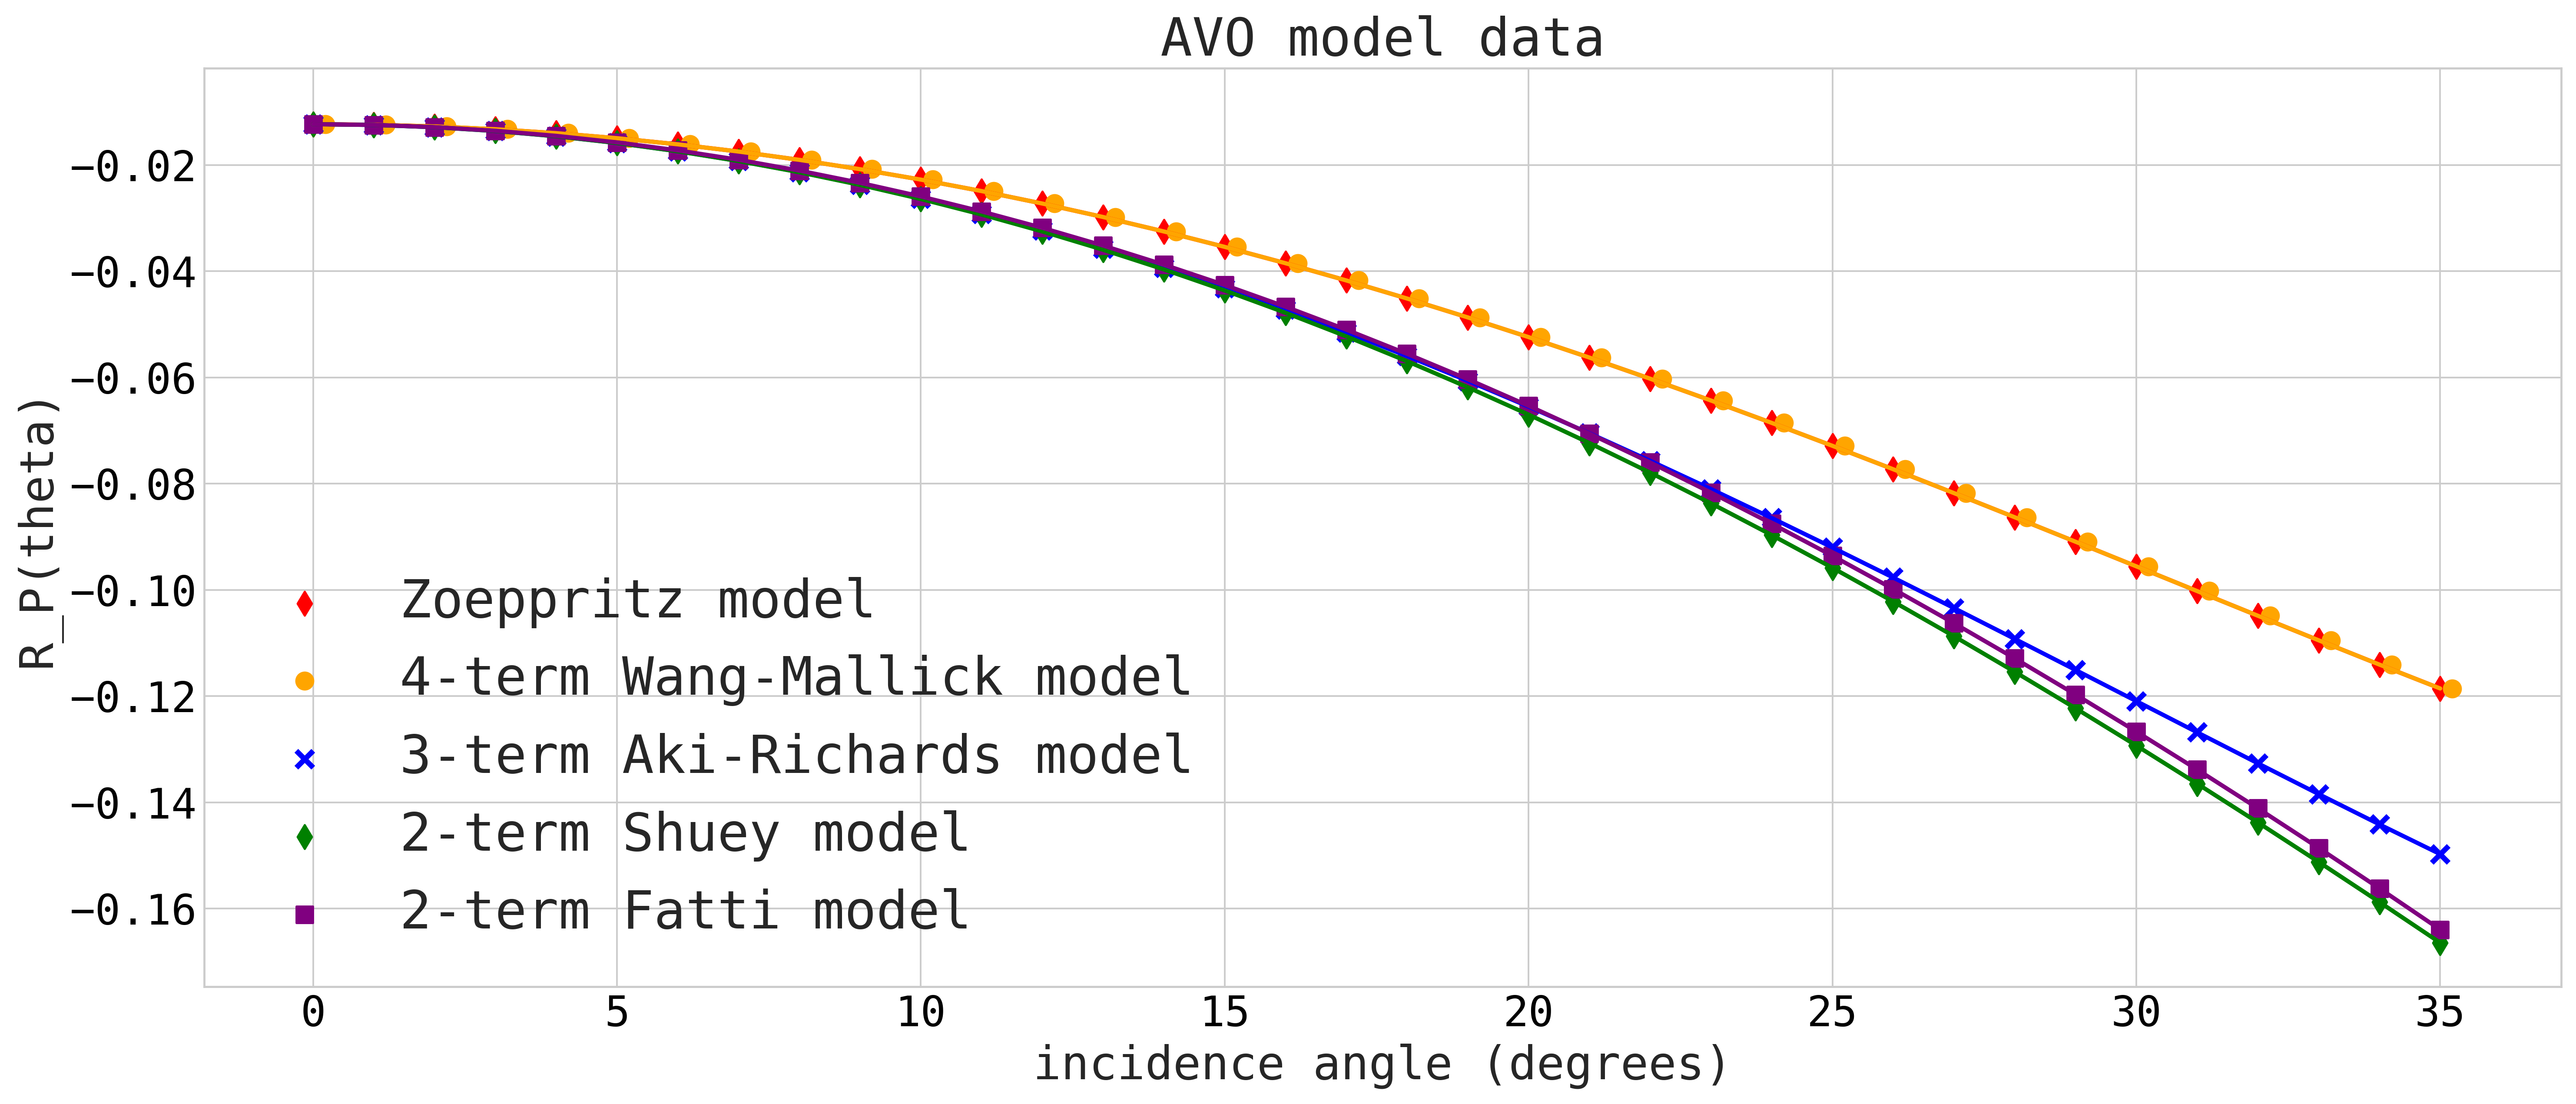

In [35]:
############
print('maxangle', maxangle)
print('max average angle', np.degrees(avtheta[nobs-1]))
#######################################
plt.rcParams["figure.figsize"] = (20,8)
mpl.rcParams['figure.dpi']= 350
# Plot Zoeppritz model 
Y_Zoepp = Y_ARShuey4T
plt.scatter(Xplot, Y_Zoepp, c='red', marker='d', label='Zoeppritz model')
plt.plot(Xplot, Y_Zoepp, c='red',   linewidth=2)
# Plot 4 term model Wang Mallick
plt.scatter(Xplot+0.2, Y_ARShuey4T, color='orange', marker='o', label='4-term Wang-Mallick model')
plt.plot(Xplot, Y_ARShuey4T, color='orange', linewidth=2)
# Plot 3 term model AR
plt.scatter(Xplot, Y_ARShuey3T, color='blue', marker='x', label='3-term Aki-Richards model')
plt.plot(Xplot, Y_ARShuey3T, color='blue', linewidth=2)
# Plot 2 term model Shuey
plt.scatter(Xplot, Y_ARShuey2T, color='green', marker='d', label='2-term Shuey model')
plt.plot(Xplot, Y_ARShuey2T, color='green', linewidth=2)
# Plot 2 term model Fatti
plt.scatter(Xplot, Y_Fatti2T, color='purple', marker='s', label='2-term Fatti model')
plt.plot(Xplot, Y_Fatti2T, color='purple', linewidth=2)
# Plot periphery
#
plt.title('AVO model data', fontsize=25)
plt.xlabel(xlabel)
plt.ylabel('R_P(theta)')
#
plt.legend(loc='best', fontsize = 25)
plt.tick_params(axis='x', labelcolor='black', labelsize=20)
plt.tick_params(axis='y', labelcolor='black', labelsize=20)
#
printZoeppritzModel(vp1, vp2, vs1, vs2, rho1, rho2)
print('3-term model params for Aki Richards are')
print('R(0) = %f'% R0)
print('G = %f'% G)
print('C = %f'% C)
print('Rd = %f'% Rd)
print('R0-C = %f'% (R0-C))
#plt.savefig('TLEHoeber2021_Fig1left.jpg')
plt.show()

***Discussion of figure above***

Mis-specification Bias can be understood by noting the difference between the models. Assume the data follow physics which is described by the Zoeppritz equation. No matter how we define the model in the least-squares fitting, the model parameters will try to adjust to match the data. Suppose we only use 2 terms, as in the 2-term Shuey model. What we would really like from the model parameters is for them to match the corresponding 2-term Shuey model; however, the data-fit forces the two parameters to match the actual data. This introduces bias into the 2 model parameters.

## Figure 1 right:
Plot residuals of different AVO models to Zoeppritz model.

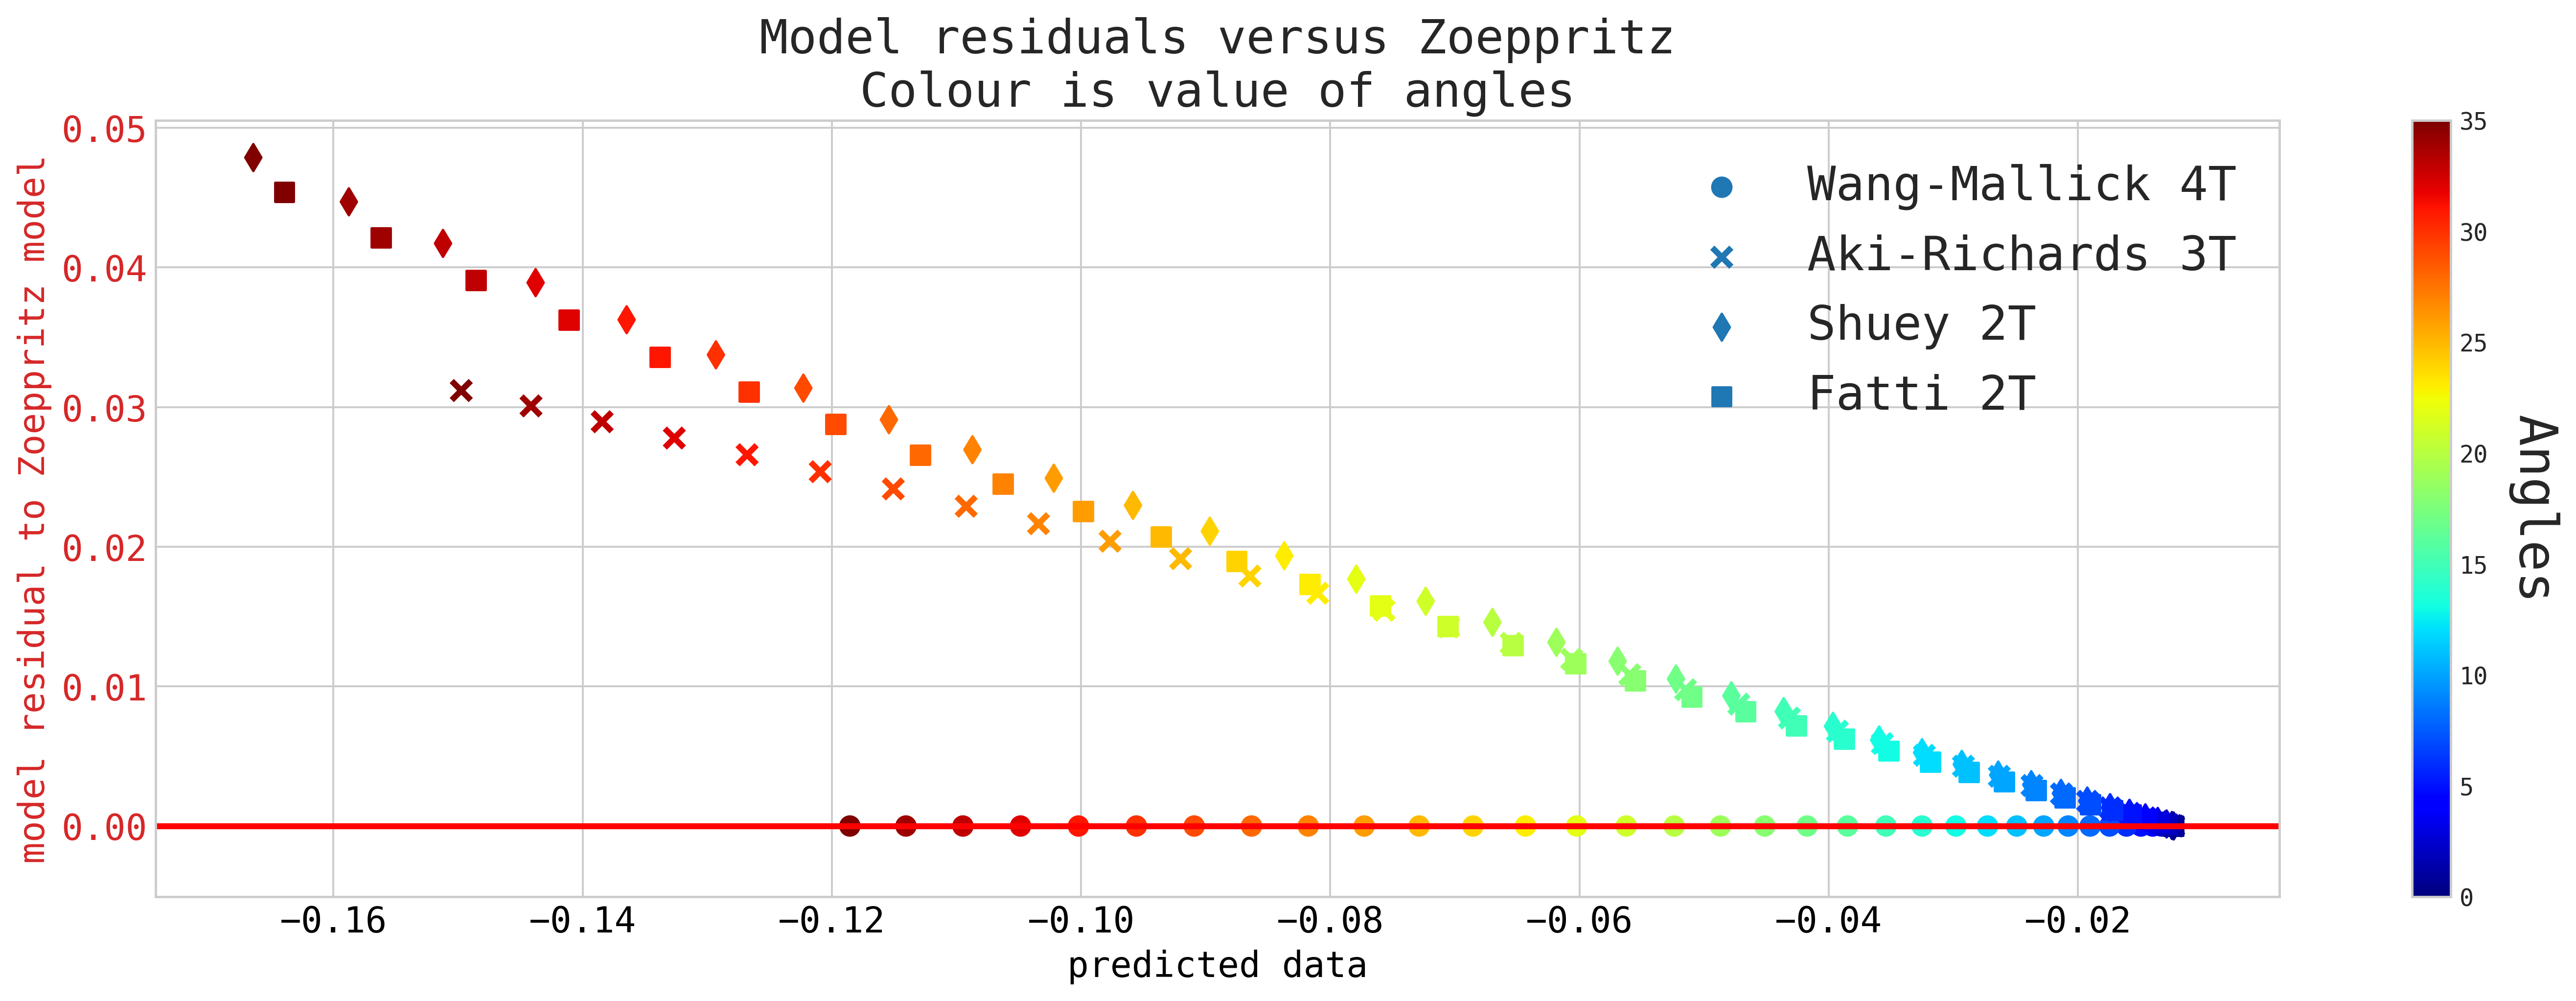

Sum of squares for the Wang-Mallick model = 0.000000
Sum of squares for the AR model = 0.009058
Sum of squares for the Shuey 2T = 0.016056
Sum of squares for the Fatti 2T = 0.013703


In [36]:
mpl.rcParams['figure.dpi']= 350
#### 2-term Shuey model and least squares
resWM      = Y_Zoepp - Y_ARShuey4T
resAR      = Y_Zoepp - Y_ARShuey3T
resShuey2T = Y_Zoepp - Y_ARShuey2T
resFatti2T = Y_Zoepp - Y_Fatti2T
## Calculate the sum of least-squares for both
totresidWM        = np.sum(resWM*resWM)
totresidAR        = np.sum(resAR*resAR)
totresidShuey2T   = np.sum(resShuey2T*resShuey2T)
totresidFatti2T   = np.sum(resFatti2T*resFatti2T)
#
fig, ax1 = fig, ax = plt.subplots(figsize=(20, 6))
color = 'tab:red'
ax1.axhline(y=0.0, color='r', linestyle='-')
z1=ax1.scatter(Y_ARShuey4T, resWM, c=Xplot, marker='o', label='Wang-Mallick 4T', cmap='jet')
z1=ax1.scatter(Y_ARShuey3T, resAR, c=Xplot, marker='x', label='Aki-Richards 3T', cmap='jet')
z1=ax1.scatter(Y_ARShuey2T, resShuey2T, c=Xplot, marker='d', label='Shuey 2T', cmap='jet')
z1=ax1.scatter(Y_Fatti2T, resFatti2T, c=Xplot, marker='s', label='Fatti 2T', cmap='jet')
#
clb=plt.colorbar(z1, ax=ax1)
clb.set_label('Angles', rotation=270, labelpad=+30)
ax1.legend(loc='best', fontsize=20)
ax1.set_title('Model residuals versus Zoeppritz\nColour is value of angles', fontsize=20)
ax1.set_xlabel('predicted data', color='black', size=15)
ax1.set_ylabel('model residual to Zoeppritz model', color = color, size=15)
ax1.tick_params(axis='x', labelcolor='black', labelsize=15)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
y_min, y_max = ax1.axes.get_ylim()
#plt.savefig('TLEHoeber2021_Fig1right.jpg')
plt.show()
#
print('Sum of squares for the Wang-Mallick model = %f' % totresidWM)
print('Sum of squares for the AR model = %f' % totresidAR)
print('Sum of squares for the Shuey 2T = %f'% totresidShuey2T)
print('Sum of squares for the Fatti 2T = %f' % totresidFatti2T)

***Run some data fits using simple least squares theory***

In [37]:
print('*********************2-term Shuey fit to Wang-Mallick ***************************')
print('3-term model params for Aki Richards are')
print('R(0) = %f'% R0)
print('G    = %f'% G)
print('C    = %f'% C)
#Shuey 2-term fitting to 4-term model data
X0 = np.ones(nobs)
X1 = np.sin(avtheta)**2
A = np.column_stack( ( X0,X1 )) 
print('condition number for the Shuey 2-term matrix=', np.linalg.cond(A))
# solve
ATA    = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY    = np.dot(A.transpose(),Y_ARShuey4T)
ModelShuey2t  = np.dot(ATAINV,ATY) # SOLUTION
dataModelShuey2t   =np.dot(A,ModelShuey2t)
print('2 term fit range (incidence angle)', avtheta[0], math.degrees(theta1[nangle-1]))
print('2 term fit range (average angle)', avtheta[0], math.degrees(avtheta[nangle-1]))
print('Two-term fit result of Shuey AVO model to noise free 4-term Model')
print('hat R(0) = %f'% ModelShuey2t[0])
print('hat G    = %f'% ModelShuey2t[1])

*********************2-term Shuey fit to Wang-Mallick ***************************
3-term model params for Aki Richards are
R(0) = -0.012317
G    = -0.403349
C    = 0.070632
condition number for the Shuey 2-term matrix= 8.547719302995135
2 term fit range (incidence angle) 0.0 35.0
2 term fit range (average angle) 0.0 38.17893233449576
Two-term fit result of Shuey AVO model to noise free 4-term Model
hat R(0) = -0.013131
hat G    = -0.283067


In [38]:
print('*********************2-term Fatti fit to Wang-Mallick ***************************')
################################
print('3-term model params for Fatti are')
print('RIp = %f'% RIp)
print('RIs    = %f'% RIs)
print('Rd    = %f'% Rd)
###################
# Create 2 term matrix for Fatti
g2 = gamma**2 
XX0F  = 1 + (np.tan(avtheta))**2
XX1F  = -8*g2*(np.sin(avtheta))**2
# solve
A = np.column_stack( (XX0F, XX1F))
print('condition number for the Fatti 2-term matrix=', np.linalg.cond(A))
# solve
ATA    = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY    = np.dot(A.transpose(),Y_ARShuey4T)
ModelFatti2t    = np.dot(ATAINV,ATY) # SOLUTION
dataModelFatti2t=np.dot(A,ModelFatti2t)
print('2 term fit range (incidence angle)', avtheta[0], math.degrees(theta1[nangle-1]))
print('2 term fit range (average angle)', avtheta[0], math.degrees(avtheta[nangle-1]))
print('Two-term fit result of Fatti AVO model to noise free 4-term Model')
print('hat RIp = %f'% ModelFatti2t[0])
print('hat RIs = %f'% ModelFatti2t[1])

*********************2-term Fatti fit to Wang-Mallick ***************************
3-term model params for Fatti are
RIp = -0.012317
RIs    = 0.161037
Rd    = -0.082949
condition number for the Fatti 2-term matrix= 5.716570039328085
2 term fit range (incidence angle) 0.0 35.0
2 term fit range (average angle) 0.0 38.17893233449576
Two-term fit result of Fatti AVO model to noise free 4-term Model
hat RIp = -0.013370
hat RIs = 0.112450


In [39]:
#Shuey original 3-term fitting
X2 = (np.tan(avtheta))**2 - (np.sin(avtheta))**2
A = np.column_stack( (np.ones(nobs), X1, X2 )) 
# solve
ATA = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY = np.dot(A.transpose(),Y_ARShuey4T)
ModelShuey3t = np.dot(ATAINV,ATY) # SOLUTION
dataModelShuey3t =np.dot(A,ModelShuey3t)
print('three-term fit result of original Shuey AVO model to noise free 4-term Model')
print('hat R(0) = %f'% ModelShuey3t[0])
print('hat G    = %f'% ModelShuey3t[1])
print('hat C    = %f'% ModelShuey3t[2])

three-term fit result of original Shuey AVO model to noise free 4-term Model
hat R(0) = -0.012245
hat G    = -0.302870
hat C    = 0.039083


## Figure 2 left:
Plot different AVO models and compare to Shuey 2-term fit when the model has four terms. 

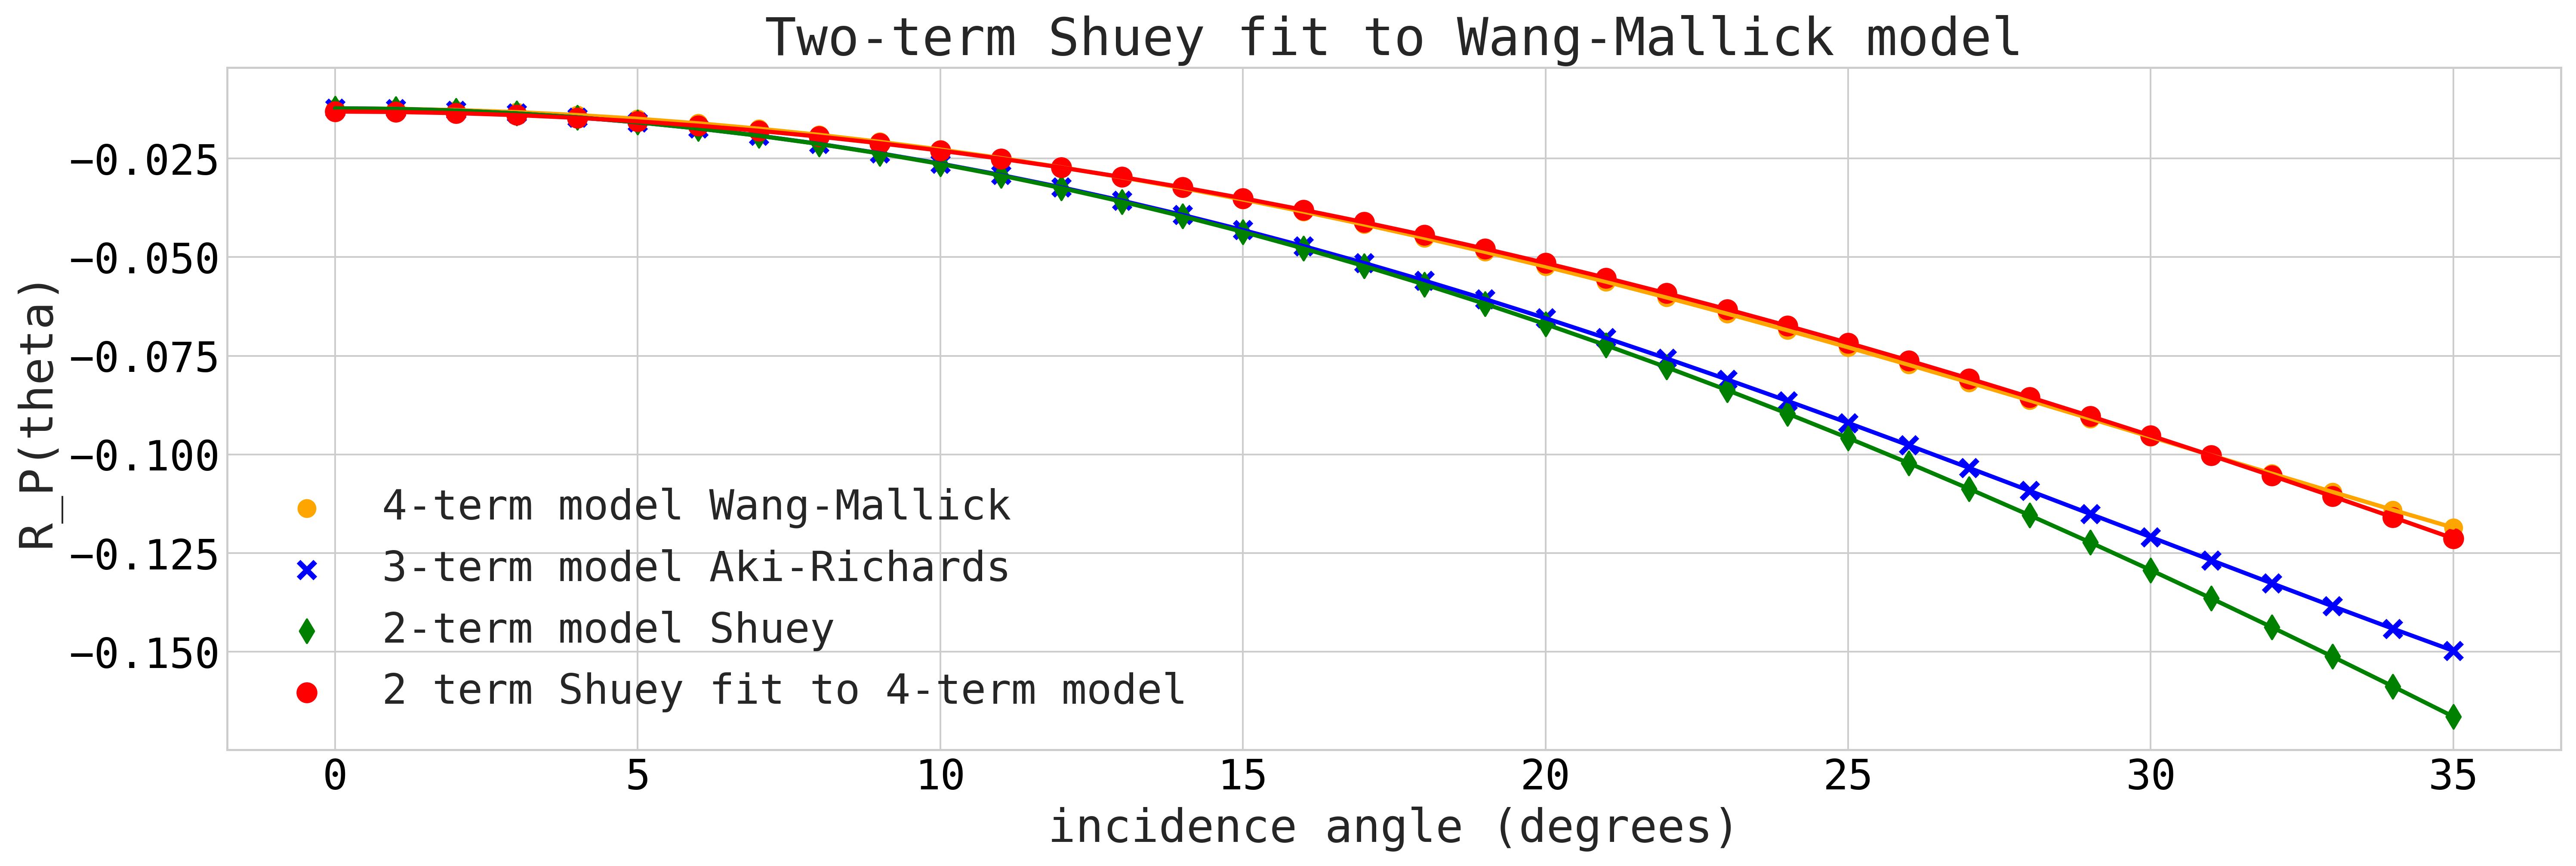

In [40]:
plt.rcParams["figure.figsize"] = (20,6)
mpl.rcParams['figure.dpi']= 350
plt.xlabel(xlabel)
#
# Plot 4 term model Wang Mallick
plt.scatter(Xplot, Y_ARShuey4T, color='orange', marker='o', label='4-term model Wang-Mallick ')
plt.plot(Xplot, Y_ARShuey4T, color='orange', linewidth=2)
# Plot 3 term model AR
plt.scatter(Xplot, Y_ARShuey3T, color='blue', marker='x', label='3-term model Aki-Richards')
plt.plot(Xplot, Y_ARShuey3T, color='blue', linewidth=2)
# Plot 2 term model Shuey
plt.scatter(Xplot, Y_ARShuey2T, color='green', marker='d', label='2-term model Shuey')
plt.plot(Xplot, Y_ARShuey2T, color='green', linewidth=2)
# Plot 2-term Shuey fit
plt.plot(Xplot, dataModelShuey2t, color='red', linewidth=2)
plt.scatter(Xplot, dataModelShuey2t, color='red', linewidth=2, label='2 term Shuey fit to 4-term model')
# Plot periphery
#
plt.title('Two-term Shuey fit to Wang-Mallick model', fontsize=25)
plt.ylabel('R_P(theta)')
#
plt.legend(loc='best',fontsize=20)
plt.tick_params(axis='x', labelcolor='black', labelsize=20)
plt.tick_params(axis='y', labelcolor='black', labelsize=20)
#plt.savefig('TLEHoeber2021_Fig2left.jpg')
plt.show()

***Discussion of figure above***

The fit using two terms matches the data which has four terms. This means the model parameters are biased. Unbiased model parameters would model the 2-term Shuey model.

## Figure 2 right:
Plot different AVO models and compare to Shuey 2-term fit when the model has three terms. 

In [41]:
print('*********************2-term Shuey fit to Aki-Richards ***************************')
#Shuey 2-term fitting to 3-term model data
X0 = np.ones(nobs)
X1 = np.sin(avtheta)**2
A = np.column_stack( ( X0,X1 )) 
print('condition number for the Shuey 2-term matrix=', np.linalg.cond(A))
# solve
ATA    = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY    = np.dot(A.transpose(),Y_ARShuey3T)
ModelShuey2ta  = np.dot(ATAINV,ATY) # SOLUTION
dataModelShuey2ta=np.dot(A,ModelShuey2ta)
print('2 term fit range (incidence angle)', avtheta[0], math.degrees(theta1[nangle-1]))
print('2 term fit range (average angle)', avtheta[0], math.degrees(avtheta[nangle-1]))
print('Two-term Shuey fit result to noise free 3-term Aki-Richards Model')
print('hat R(0) = %f'% ModelShuey2ta[0])
print('hat G    = %f'% ModelShuey2ta[1])

*********************2-term Shuey fit to Aki-Richards ***************************
condition number for the Shuey 2-term matrix= 8.547719302995135
2 term fit range (incidence angle) 0.0 35.0
2 term fit range (average angle) 0.0 38.17893233449576
Two-term Shuey fit result to noise free 3-term Aki-Richards Model
hat R(0) = -0.013918
hat G    = -0.367562


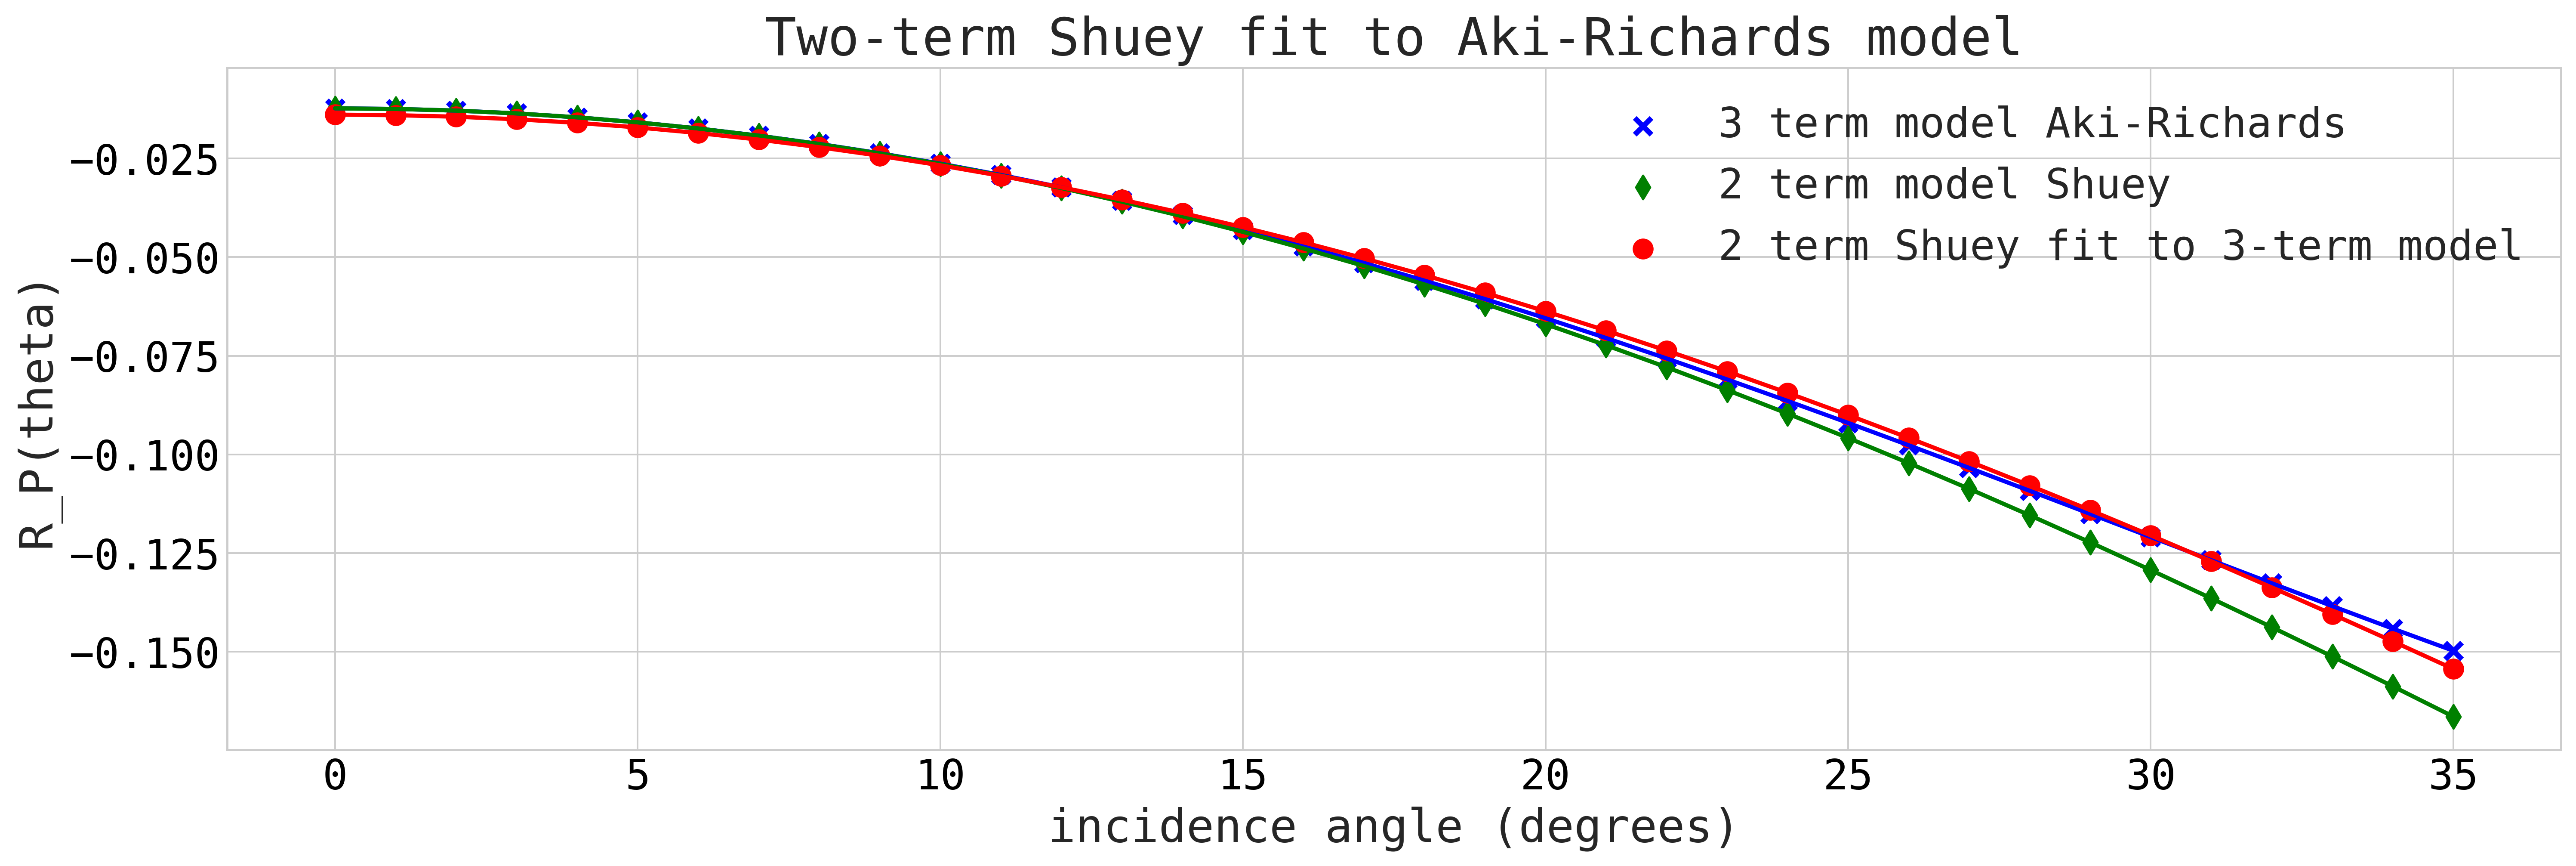

In [42]:
plt.rcParams["figure.figsize"] = (20,6)
mpl.rcParams['figure.dpi']= 350
plt.xlabel(xlabel)
#
# Plot 3-term model Aki-Richards
plt.scatter(Xplot, Y_ARShuey3T, color='blue', marker='x', label='3 term model Aki-Richards')
plt.plot(Xplot, Y_ARShuey3T, color='blue', linewidth=2)
# Plot 2-term Shuey model
plt.scatter(Xplot, Y_ARShuey2T, color='green', marker='d', label='2 term model Shuey')
plt.plot(Xplot, Y_ARShuey2T, color='green', linewidth=2)
# Plot 2-term Shuey fit 3-term model
plt.plot(Xplot, dataModelShuey2ta, color='red', linewidth=2)
plt.scatter(Xplot, dataModelShuey2ta, color='red', marker='o',linewidth=2, label='2 term Shuey fit to 3-term model')
# Plot periphery
#
plt.title('Two-term Shuey fit to Aki-Richards model', fontsize=25)
plt.ylabel('R_P(theta)')
#
plt.legend(loc='best',fontsize=20)
plt.tick_params(axis='x', labelcolor='black', labelsize=20)
plt.tick_params(axis='y', labelcolor='black', labelsize=20)
#plt.savefig('TLEHoeber2021_Fig2right.jpg')
plt.show()

***Discussion of figure above***

Same story as in the image before: The fit using two terms matches the data, which now has three terms. This means the model parameters are biased. Unbiased model parameters would model the 2-term Shuey model.

No matter what variability is in the data, the least-squares algorithms minimizes the misfit as best it can, since that is the idea of least-squares fitting/inversion. To do that is adjusts the available parameters, and if there are less parameters than in the model, i.e. the model is mis-specified, then the model parameters are biased.

## Extra figure: 
Make a plot of misfits of 2-term model to 4 term model and compare 2-term fit residuals 

Extra figure: Make a plot of misfits of 2-term model to 4 term model and compare 2-term fit residuals


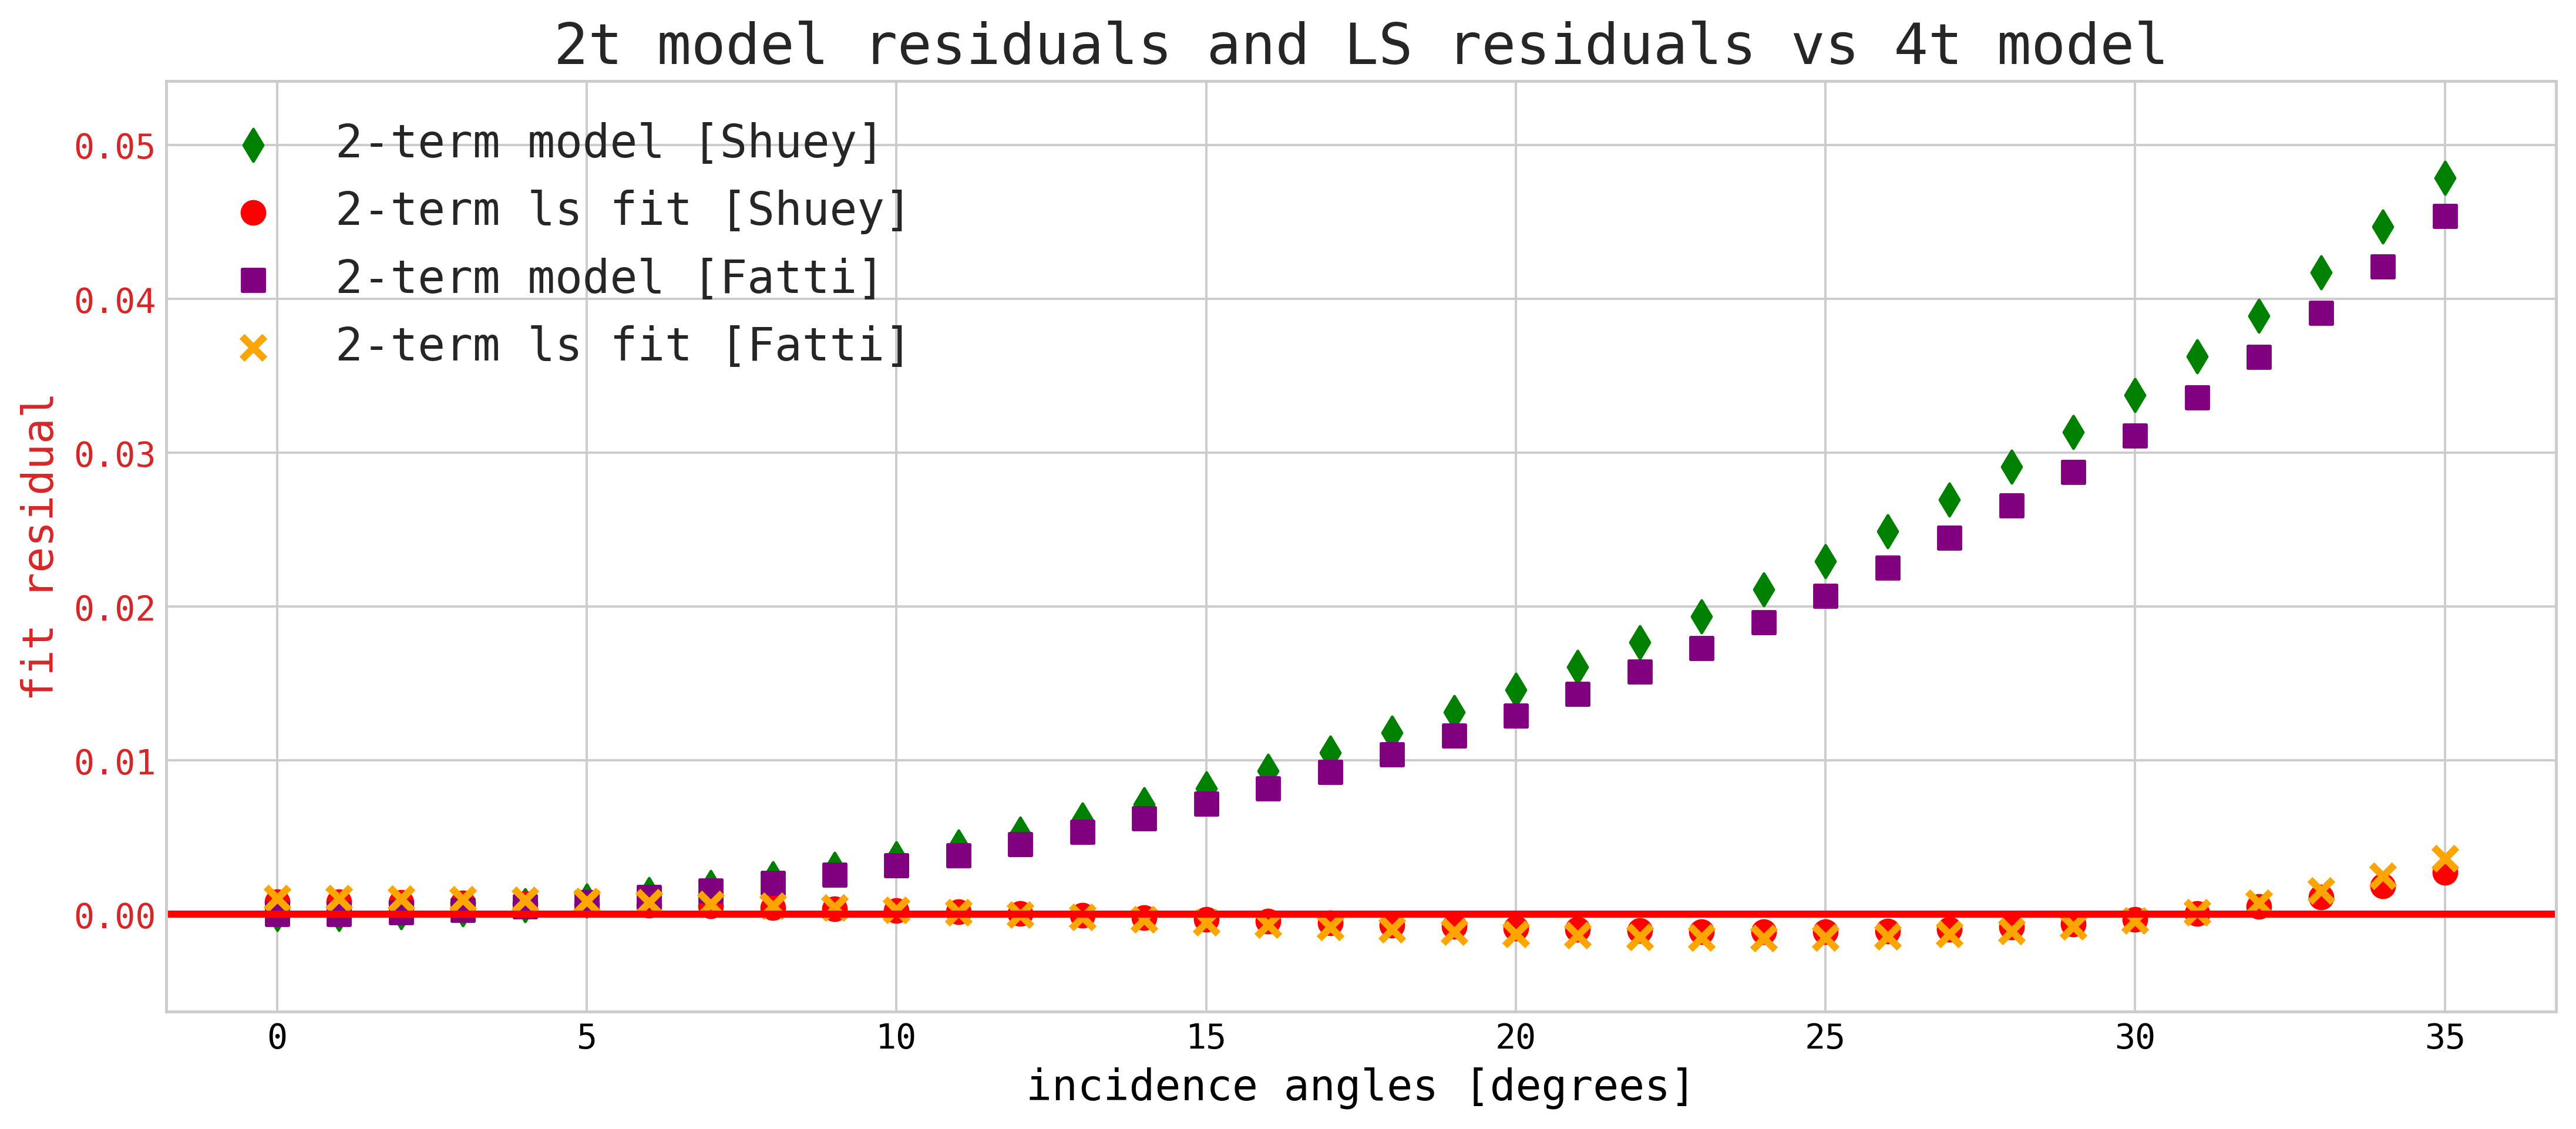

Sum of squares for the Shuey model = 0.016056
Sum of squares for the Shuey fit = 0.000029
Sum of squares for the Fatti model = 0.013703
Sum of squares for the Fatti fit = 0.000052


In [43]:
print("Extra figure: Make a plot of misfits of 2-term model to 4 term model and compare 2-term fit residuals")
#### 2-term Shuey model and least squares
resModel = Y_ARShuey4T - Y_ARShuey2T
resSLS   = Y_ARShuey4T - dataModelShuey2t
resModelFatti = Y_ARShuey4T - Y_Fatti2T
resSLSFatti   = Y_ARShuey4T - dataModelFatti2t
## Calculate the sum of least-squares for both
totresidSLS = np.sum(resSLS*resSLS)
totresidModel = np.sum(resModel*resModel)
totresidSLSF = np.sum(resSLSFatti*resSLSFatti)
totresidModelF = np.sum(resModelFatti*resModelFatti)
#
fig, ax1 = fig, ax = plt.subplots(figsize=(15, 6))
color = 'tab:red'
ax1.axhline(y=0.0, color='r', linestyle='-')
## x-axis = angles
## y-axis = residual to analytic model data
z1=ax1.scatter(Xplot, resModel,      marker='d', color='green', label='2-term model [Shuey]')
z1=ax1.scatter(Xplot, resSLS, marker='o', color='red', label='2-term ls fit [Shuey]')
z1=ax1.scatter(Xplot, resModelFatti, marker='s', color='purple',label='2-term model [Fatti]')
z1=ax1.scatter(Xplot,   resSLSFatti, marker='x', color='orange',label='2-term ls fit [Fatti]')
ax1.legend(loc='best',fontsize=16)
ax1.set_title('2t model residuals and LS residuals vs 4t model', fontsize=20)
ax1.set_xlabel('incidence angles [degrees]', color='black', size=15)
ax1.set_ylabel('fit residual', color = color, size=15)
ax1.tick_params(axis='x', labelcolor='black', labelsize=12)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
y_min, y_max = ax1.axes.get_ylim()
plt.show()
print('Sum of squares for the Shuey model = %f' % totresidModel)
print('Sum of squares for the Shuey fit = %f' % totresidSLS)
print('Sum of squares for the Fatti model = %f' % totresidModelF)
print('Sum of squares for the Fatti fit = %f' % totresidSLSF)

***Discussion of figure above***

This is another good figure to understand bias: The 2-term models for both Shuey and Fatti are quite different to the 4-term model of Wang-Mallick. However, the respective fits, with 2 terms, fit the 4-term model rather well! The 2-term fits have smaller residuals than the 2-term models. This can only happen if the model parameters from the fit are adjusted by the least-squares algorithm, to match the data. Bias in action... Ideally, when fitting with 2 terms, we would like the model that this creates to be equal the underlying 2-term model -- which of course we do not have; all we have is the data, which (in this case) has variability described by 4 parameters.

## Bias Calculation of the two-term Shuey fit with a 4-term AVO model
We now calculate the weight term matrix, and then the bias terms and show that adding the bias terms obtained in this way, for the third term and the quadratic term, give us back the unbiased model parameters.
The example below is set up for the Shuey case.

The weight term (matrix)  $$\bf A_{i}^{-g} \bf A_{o}$$ has one entry for each combination of included and omitted variable.


<font color=darkblue> 
The included basis functions go into $A_i$.
</font>

In [44]:
# included basis functions are the same as Shuey 2-term fitting 
X0 = np.ones(nobs)
X1 = np.sin(avtheta)**2
Ai = np.column_stack( (X0,X1) )
ATA    = np.dot(Ai.transpose(),Ai)
ATAINV = np.linalg.inv(ATA)

<font color=darkblue> 
The excluded basis functions go into $A_o$.
</font>

In [45]:
#term2 = X2 * C 
#term3 = X3 * (drho/rho + 2 * dvs/vs)**2
X2 = (np.tan(avtheta))**2 - (np.sin(avtheta))**2
X3 = (np.sin(avtheta))**2 * (np.cos(avtheta)) 
Ao = np.column_stack( (X2,X3) )

<font color=darkblue>
In the code that follows I use
$$
\gamma^3 \left\{ {d\rho \over \rho} + 2 {dv_S \over v_S} \right\}^2  = 4 \gamma^3 R_{vsd}^2
$$
where
$$
R_{vsd} = R_d + 2 R_{v_s}  = {1 \over 2} \left\{ {d\rho \over \rho} + 2 {dv_S \over v_S} \right\}
$$
was calculated earlier.
</font>

In [46]:
## Matrix to calculate bias in partial regression
ATA2 = np.dot(Ai.transpose(),Ao)
Bias = np.dot(ATAINV, ATA2)
print("""Bias weights in 2-term Shuey when the model has 4 parameters (Wang-Mallick)
The first column are the curvature components, the second column are the quadartic components
The first row is for the intercept, the second row is for the gradient\n""", Bias)
# To get (model) the bias due to missing the curvature term, multiply the weights with the curvature
Bias3 = Bias[:,0]*C
print('Bias due to omitted curvature in 2-term Shuey', Bias3)
print('Fits with model bias for curvature only')
print('hat R(0) = %f'% (ModelShuey2t[0] - Bias3[0]))
print('hat G    = %f'% (ModelShuey2t[1] - Bias3[1]))
# To get (model) the bias due to missing the quadratic term, multiply the weights with the quadratic term
BiasQ = Bias[:,1]*4*gamma**3 *Rvsd**2
print('Fits with model bias for 4th term only')
print('hat R(0) = %f'% (ModelShuey2t[0] - BiasQ[0]))
print('hat G    = %f'% (ModelShuey2t[1] - BiasQ[1]))
print('Bias due to omitted quadratics in 2-term Shuey', BiasQ)
ModelDeb = ModelShuey2t - Bias3 - BiasQ
print('model R(0) --> fit R(0) --> debiassed R(0) %f' % R0, '--> %f' % ModelShuey2t[0], ' --> %f '% ModelDeb[0])
print('model G    --> fit G    --> debiassed G    %f' % G , '--> %f' % ModelShuey2t[1], ' --> %f' % ModelDeb[1])

Bias weights in 2-term Shuey when the model has 4 parameters (Wang-Mallick)
The first column are the curvature components, the second column are the quadartic components
The first row is for the intercept, the second row is for the gradient
 [[-0.0227  0.0076]
 [ 0.5067  0.8137]]
Bias due to omitted curvature in 2-term Shuey [-0.0016  0.0358]
Fits with model bias for curvature only
hat R(0) = -0.011530
hat G    = -0.318855
Fits with model bias for 4th term only
hat R(0) = -0.013918
hat G    = -0.367562
Bias due to omitted quadratics in 2-term Shuey [0.0008 0.0845]
model R(0) --> fit R(0) --> debiassed R(0) -0.012317 --> -0.013131  --> -0.012317 
model G    --> fit G    --> debiassed G    -0.403349 --> -0.283067  --> -0.403349


***Create the uncertainty plots for Shuey parameters based on the OVB analysis***

We now have two equations for intercept and gradient which relate the two biased calculated model parameters to the 4 unbiased paramters $(R(0), G, C, \gamma)$. To turn this into an uncertainty plot, I first use Gardner, to relate $C$ and $R(0)$ via $C = c R(0)$. I then loop over values of $c$ and $\gamma$ and plot all the possible solutions.

In [47]:
from scipy.optimize import fsolve
#####################
#####################
def equations(vars, *args):
            # solve unbiased = biased - Bias3[0] - BiasQ[0]
            #Bias3 = Bias[:,0]*c*R0
            #BiasQ = Bias[:,1] (cR0-G)**2 / (4*gamma)
            # ModelDeb = Model - Bias3 - BiasQ
            # inputs are the measured two-term fit values hat R(0) and hat G
            # outputs, if c and gamma are correct are fully debiased Shuey parameters (R0,G)
            R0,G = vars
            c, g, Bias, R0hat, Ghat  = args
            ## equation 1 is for the biased R(0)
            ## equation 2 is for the biased G
            eq1 = R0 - R0hat + Bias[0,0]*c*R0 + Bias[0,1]* (c*R0 - G)**2 /(4*g)
            eq2 = G  - Ghat  + Bias[1,0]*c*R0 + Bias[1,1]* (c*R0 - G)**2 /(4*g)
            return (eq1, eq2)
Ngammas    = 4
maxNgammas = 4
cValue  =np.zeros( (Ngammas, 101) ) # 101 are the C/R(0) values
gplay  = np.zeros( (Ngammas) )
quadTerms =np.zeros( (2, Ngammas, 101) )
# Loop over possible c values
cmin = 0
cmax = 1.5*C/R0
dc = (cmax - cmin)/100
# loop over 3 gamma values
gplay[0] = gamma - 0.1
gplay[1] = gamma
gplay[2] = 1
gplay[3] = 1000
#########################
for k in range(0, Ngammas):
    c = cmin
    g = gplay[k]
    for j in range(0, 101):
        #####################
        p = (c, g, Bias, ModelShuey2t[0], ModelShuey2t[1])
        R0i, Gi =  fsolve(equations, (0.1, 0.1), p )
        ######################
        #print('Inverted model values post orthogonal fit =', R0i, Gi)  
        quadTerms[0,k,j]=R0i
        quadTerms[1,k,j]=Gi
        cValue[k, j] = c
        c = c + dc
    #print(g)
    ##
#print(cValue)

## Extra figure: 
Intercept and gradient models as a function of C/R(0) and $\gamma$

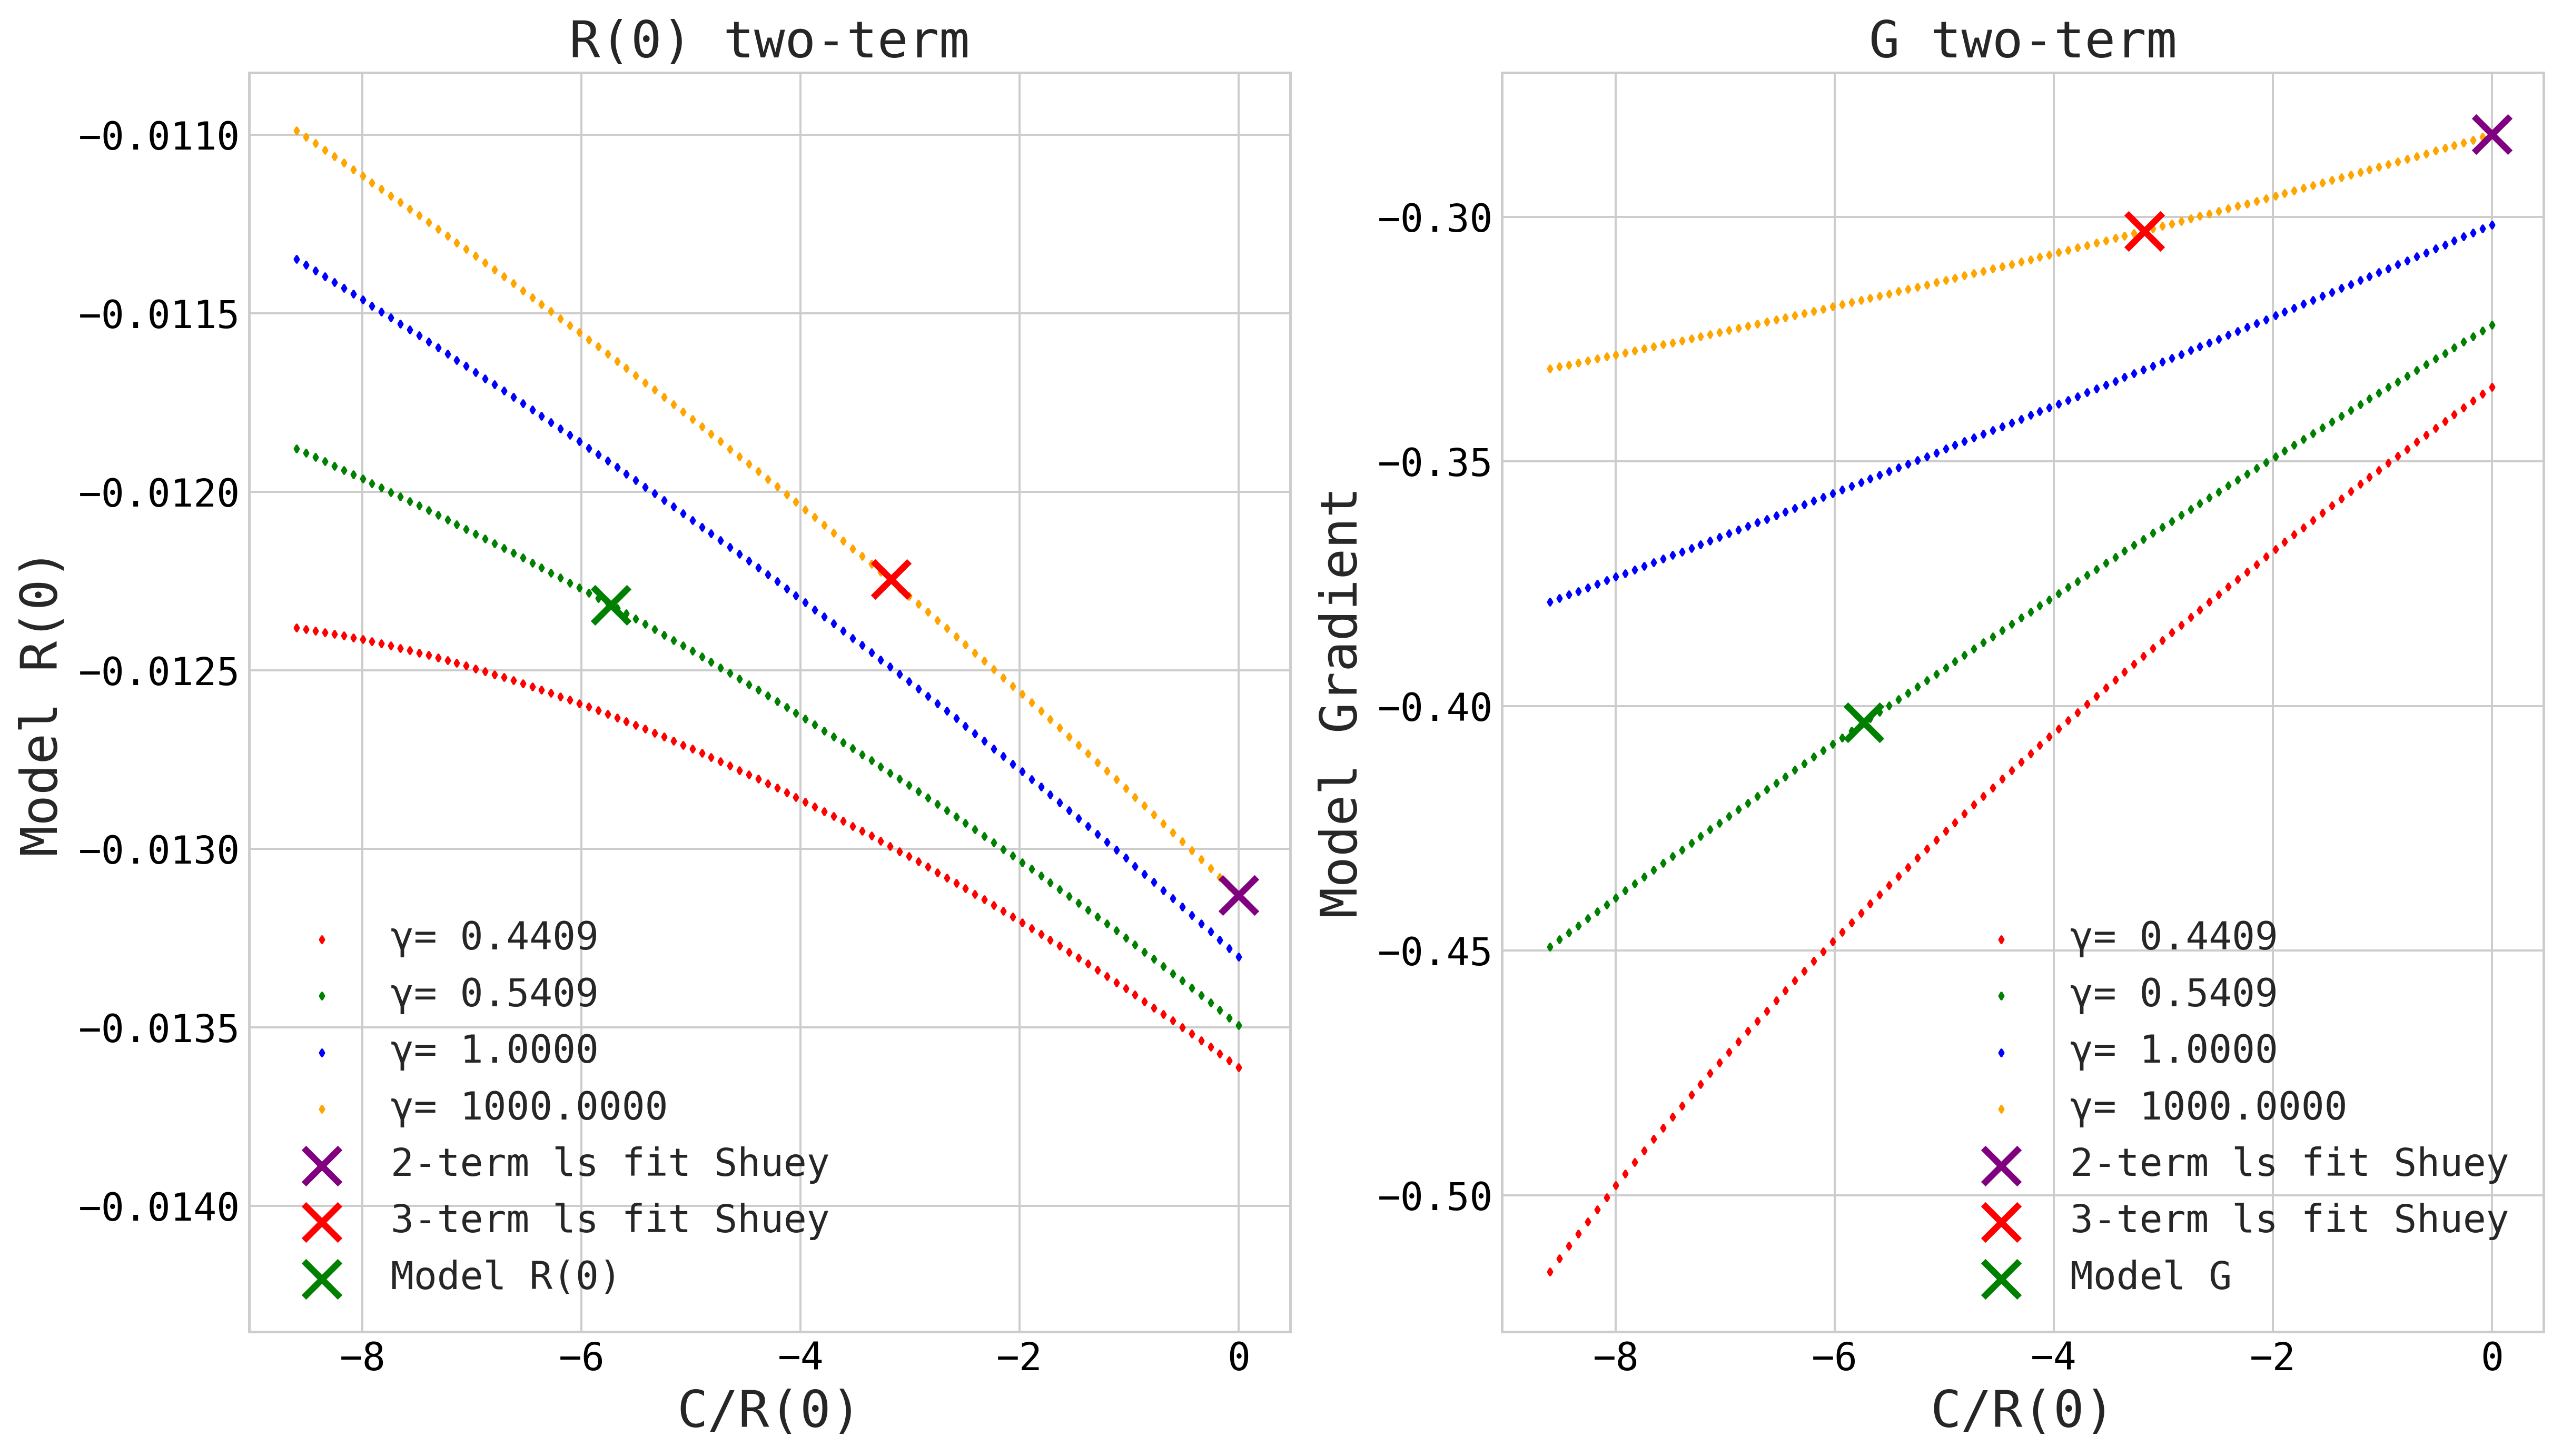

In [48]:
#######################################
plt.rcParams['axes.labelsize'] = 20
plt.rc('font',family='monospace')
fig, axs =plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14, 8))
gcol  = np.zeros( (maxNgammas) )
gcol=['red', 'green', 'blue', 'orange']
# R0 
for k in range(0, Ngammas):
    lab=''+gammauni+'= %1.4f' %(gplay[k])
    axs[0].scatter(cValue[k, :], quadTerms[0,k,:], c=gcol[k], s=3, marker='d', label=lab)
axs[0].scatter(0, ModelShuey2t[0], c='purple', s=200, marker='x', label='2-term ls fit Shuey')
axs[0].scatter(ModelShuey3t[2]/R0, ModelShuey3t[0], c='red', s=200, marker='x', label='3-term ls fit Shuey')
axs[0].scatter(C/R0, R0, c='green', s=200, marker='x', label='Model R(0)')
axs[0].set_xlabel('C/R(0)', fontsize=20)
axs[0].set_ylabel('Model R(0)', fontsize =20)
axs[0].tick_params(axis='x', labelcolor='black', labelsize=15)
axs[0].tick_params(axis='y', labelcolor='black', labelsize=15)
# G 
for k in range(0, Ngammas):
    lab=''+gammauni+'= %1.4f' %(gplay[k])
    axs[1].scatter(cValue[k, :], quadTerms[1,k,:], c=gcol[k], s=3, marker='d', label=lab)
# two-term fit ie value with c=0
axs[1].scatter(0, ModelShuey2t[1], c='purple', s=200, marker='x', label='2-term ls fit Shuey')
axs[1].scatter(ModelShuey3t[2]/R0, ModelShuey3t[1], c='red', s=200, marker='x', label='3-term ls fit Shuey')
axs[1].scatter(C/R0, G, c='green', s=200, marker='x', label='Model G')
axs[1].set_xlabel('C/R(0)', fontsize=20)
axs[1].set_ylabel('Model Gradient', fontsize =20)
axs[1].tick_params(axis='x', labelcolor='black', labelsize=15)
axs[1].tick_params(axis='y', labelcolor='black', labelsize=15)
#######
axs[0].set_title('R(0) two-term', fontsize=20)
axs[1].set_title('G two-term', fontsize = 20)
#
axs[0].legend(loc='best',fontsize=15)
axs[1].legend(loc='best',fontsize=15)
fig.tight_layout()
plt.show()

## Figure 4 left

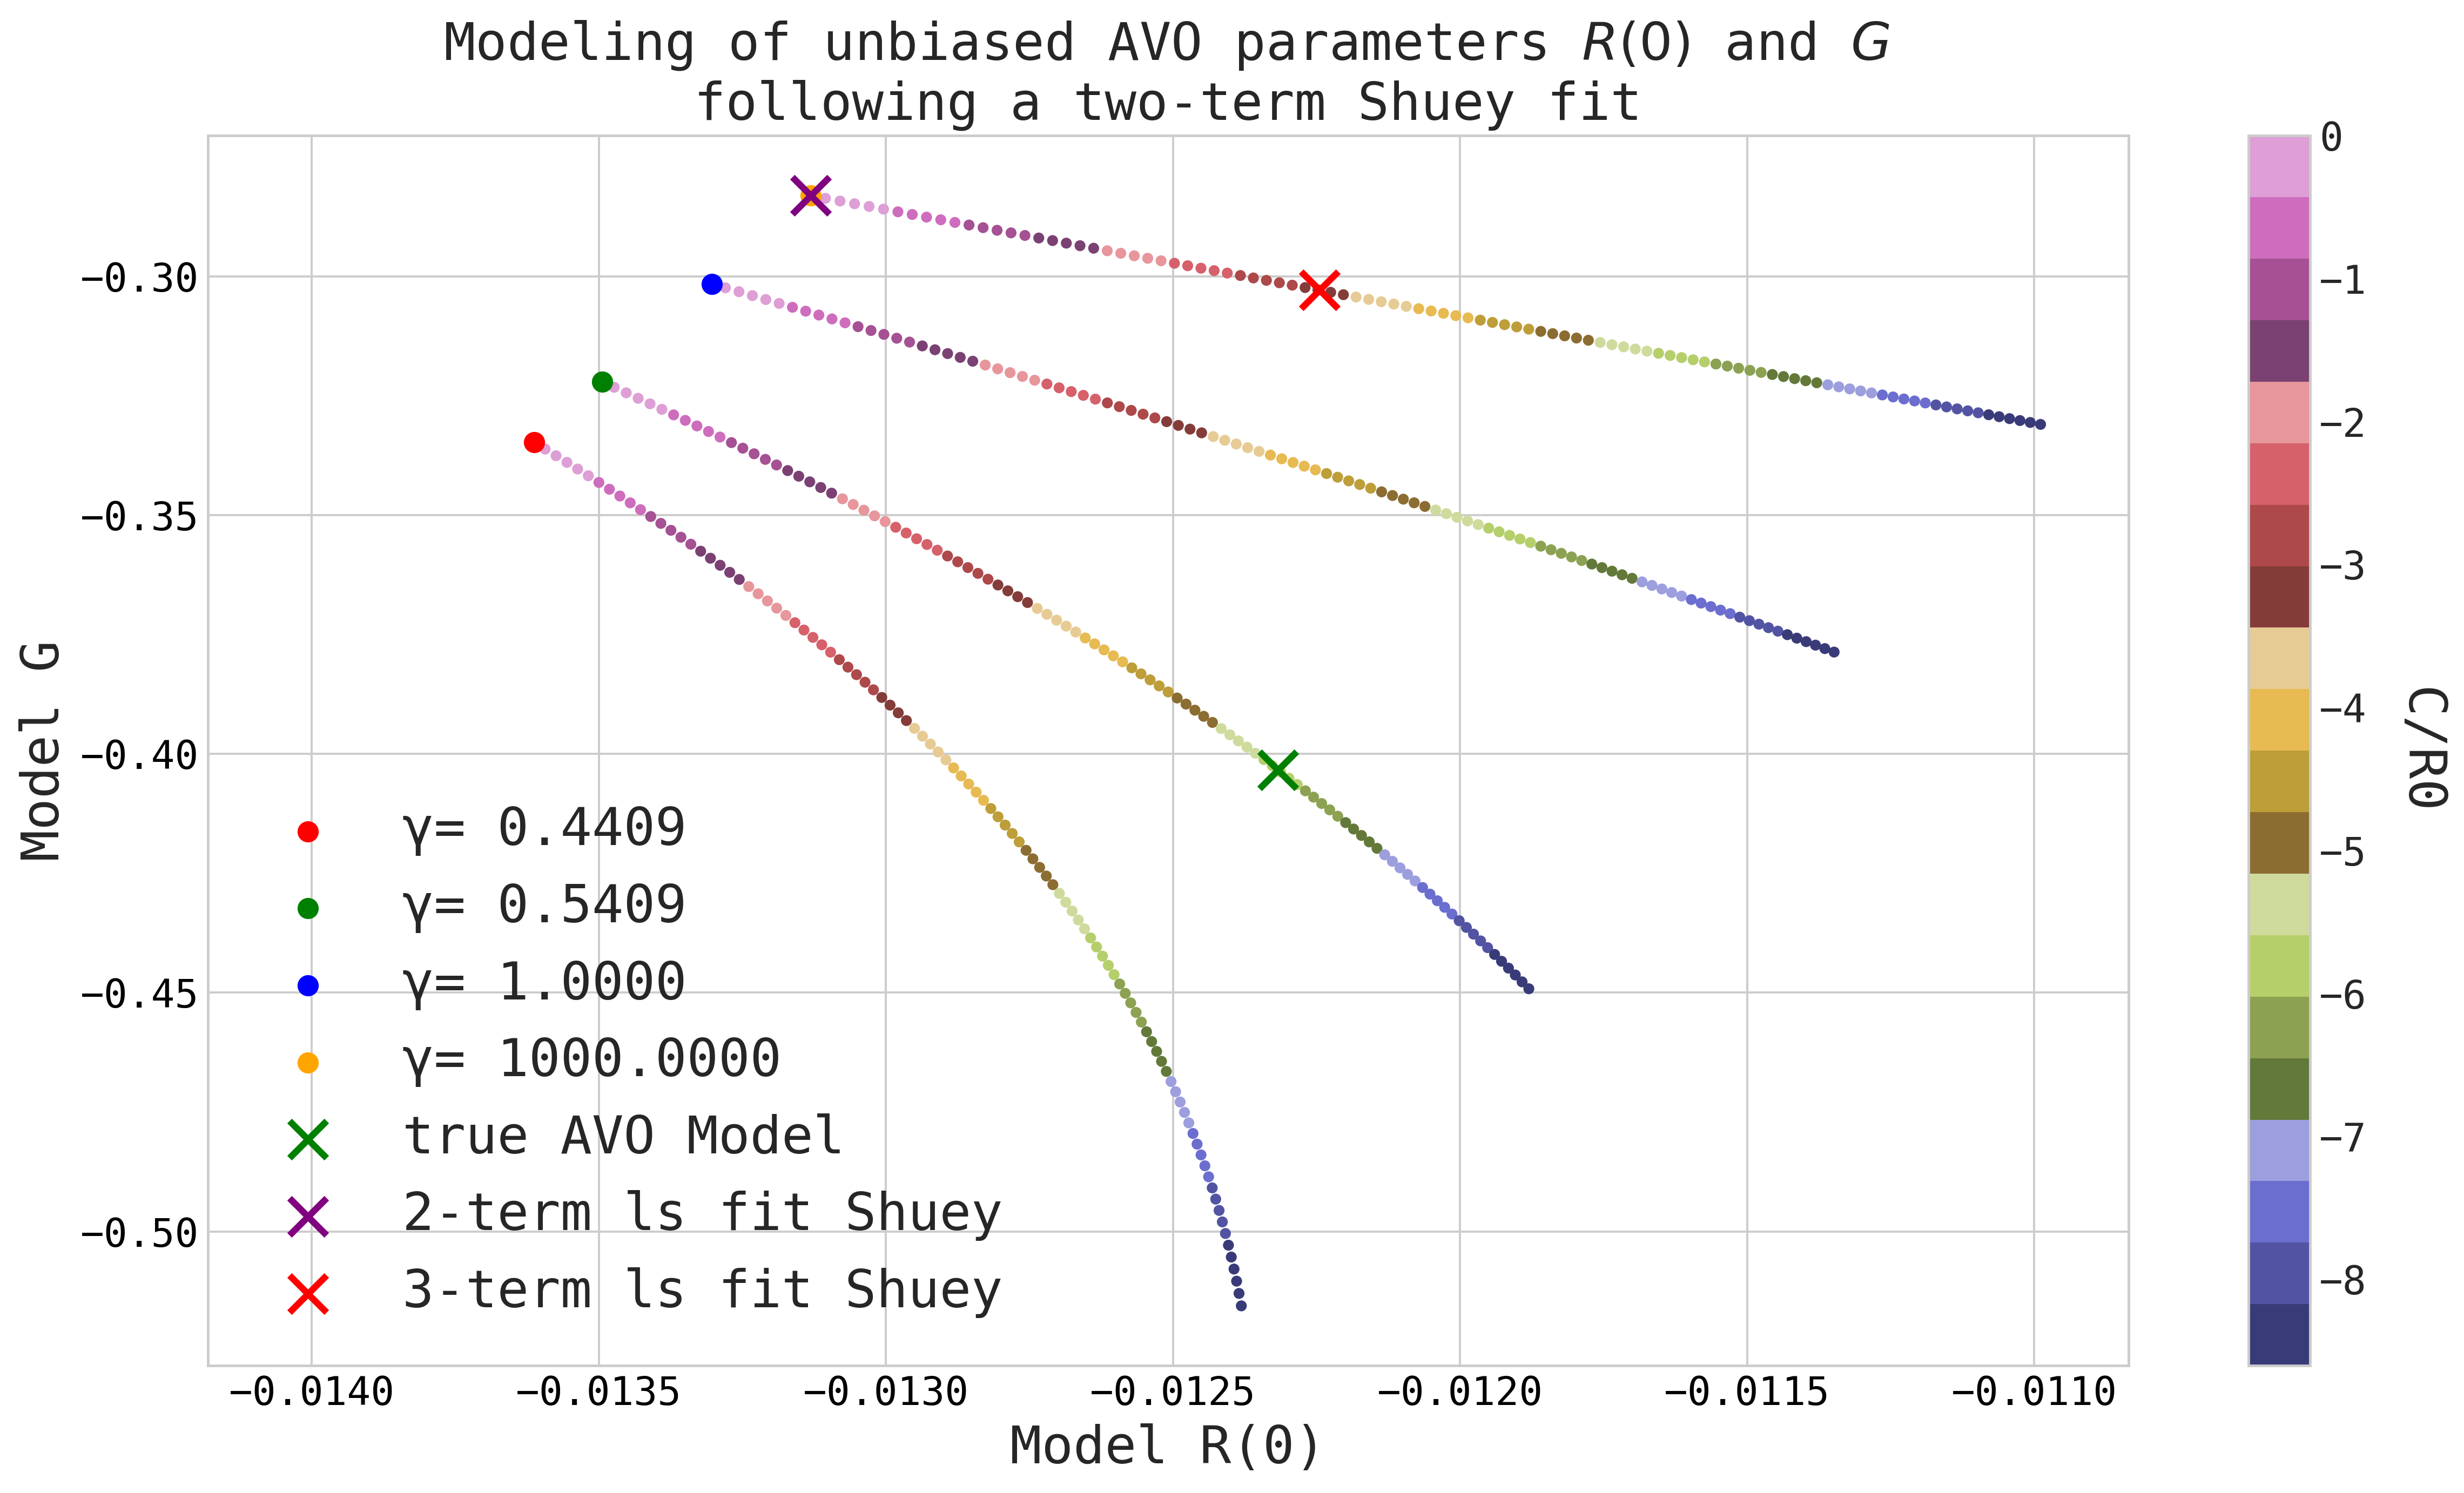

In [49]:
# Crossplot of R(0) and G
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 350
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
#######################################
# Crossplots
plt.rcParams['axes.labelsize'] = 20
plt.rc('font',family='monospace')
fig, axs =plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(14, 8))
gcol  = np.zeros( (maxNgammas) )
gcol=['red', 'green', 'blue', 'orange']
# dk 
gplay[3] = 1000
for k in range(0, Ngammas):
#    lab='g= %1.4f' %(gplay[k])
#    axs.scatter(quadTerms[0,k,:], quadTerms[1,k,:], c=gcol[k], s=3, marker='d', label=lab)
    resids=plt.scatter(quadTerms[0,k,:], quadTerms[1,k,:], s=10, c=cValue[k, :], cmap="tab20b")
    lab=''+gammauni+'= %1.4f' %(gplay[k])
    axs.scatter(quadTerms[0,k,0], quadTerms[1,k,0], c=gcol[k], s=50, marker='o', label=lab)
axs.scatter(R0, G, c='green', s=200, marker='x', label='true AVO Model')
axs.scatter(ModelShuey2t[0], ModelShuey2t[1], c='purple', s=200, marker='x', label='2-term ls fit Shuey')
axs.scatter(ModelShuey3t[0], ModelShuey3t[1], c='red', s=200, marker='x', label='3-term ls fit Shuey')
##

axs.set_xlabel('Model R(0)', fontsize=20)
axs.set_ylabel('Model G', fontsize =20)
axs.tick_params(axis='x', labelcolor='black', labelsize=15)
axs.tick_params(axis='y', labelcolor='black', labelsize=15)
###
clb=plt.colorbar(resids)
clb.set_label('C/R0', rotation=270, labelpad=+30)
clb.ax.tick_params(labelsize=15)

#######
axs.set_title('Modeling of unbiased AVO parameters $R(0)$ and $G$ \nfollowing a two-term Shuey fit', fontsize=20)
#
axs.legend(loc='best',fontsize=20)
fig.tight_layout()
#plt.savefig('TLEHoeber2021_Fig4left.jpg')
plt.show()

## Figure 4 right:
Instead of solving for R(0) and G, we can convert directly to other parameters -- let's do $R_{I_P}$ and $R_{I_S}$.

In [50]:
#####################
def avoBiasConvert1(vars, *args):
            # solve unbiased = biased - Bias3[0] - BiasQ[0]
            #Bias3 = Bias[:,0]*Rvp
            #BiasQ = Bias[:,1] 4 gamma**2 (Rrho - Rvs)**2
            # ModelDeb = Model - Bias3 - BiasQ
            # inputs are the measured two-term fit values hat R(0) and hat G
            # outputs, if Rrho and gamma are correct are fully debiased RIp and RIs
            RIp1, RIs1 = vars
            Rrho1, g, Bias, R0hat, Ghat  = args           
            ## equation 1 is for RIp
            ## equation 2 is for RIs
            eq1 = RIp1 - R0hat                                + Bias[0,0]*(RIp1-Rrho1) + Bias[0,1]* (2*RIs1-Rrho1)**2 * 4 * g**3
            eq2 = RIp1-Rrho1 - 4*g**2 * (2*RIs1 - Rrho1)-Ghat + Bias[1,0]*(RIp1-Rrho1) + Bias[1,1]* (2*RIs1-Rrho1)**2 * 4 * g**3
            return (eq1, eq2)
Ngammas    = 3
maxNgammas = 4
Rrhovalues =np.zeros( (Ngammas, 101) )
gplay      = np.zeros( (Ngammas) )
quadTerms =np.zeros( (2, Ngammas, 101) )
# Loop over possible Rrho values
Rrhomin = Rd - 0.05
Rrhomax = Rd + 0.05
dRr = (Rrhomax - Rrhomin)/100
#print(Rrhomin, Rrhomax)
# loop over 3 or 4 gamma values
gplay[0] = gamma - 0.1
gplay[1] = gamma
gplay[2] = gamma + 0.1
#########################
for k in range(0, Ngammas):
    Rrho = Rrhomin
    g = gplay[k]
    for j in range(0, 101):
        #####################
        p = (Rrho, g, Bias, ModelShuey2t[0], ModelShuey2t[1])
        RIpi, RIsi =  fsolve(avoBiasConvert1, (0.1, 0.1), p )
        ######################  
        quadTerms[0,k,j]=RIpi
        quadTerms[1,k,j]=RIsi
        Rrhovalues[k, j] = Rrho
        Rrho = Rrho + dRr
    #print(g)
    ##
#print(cValue)

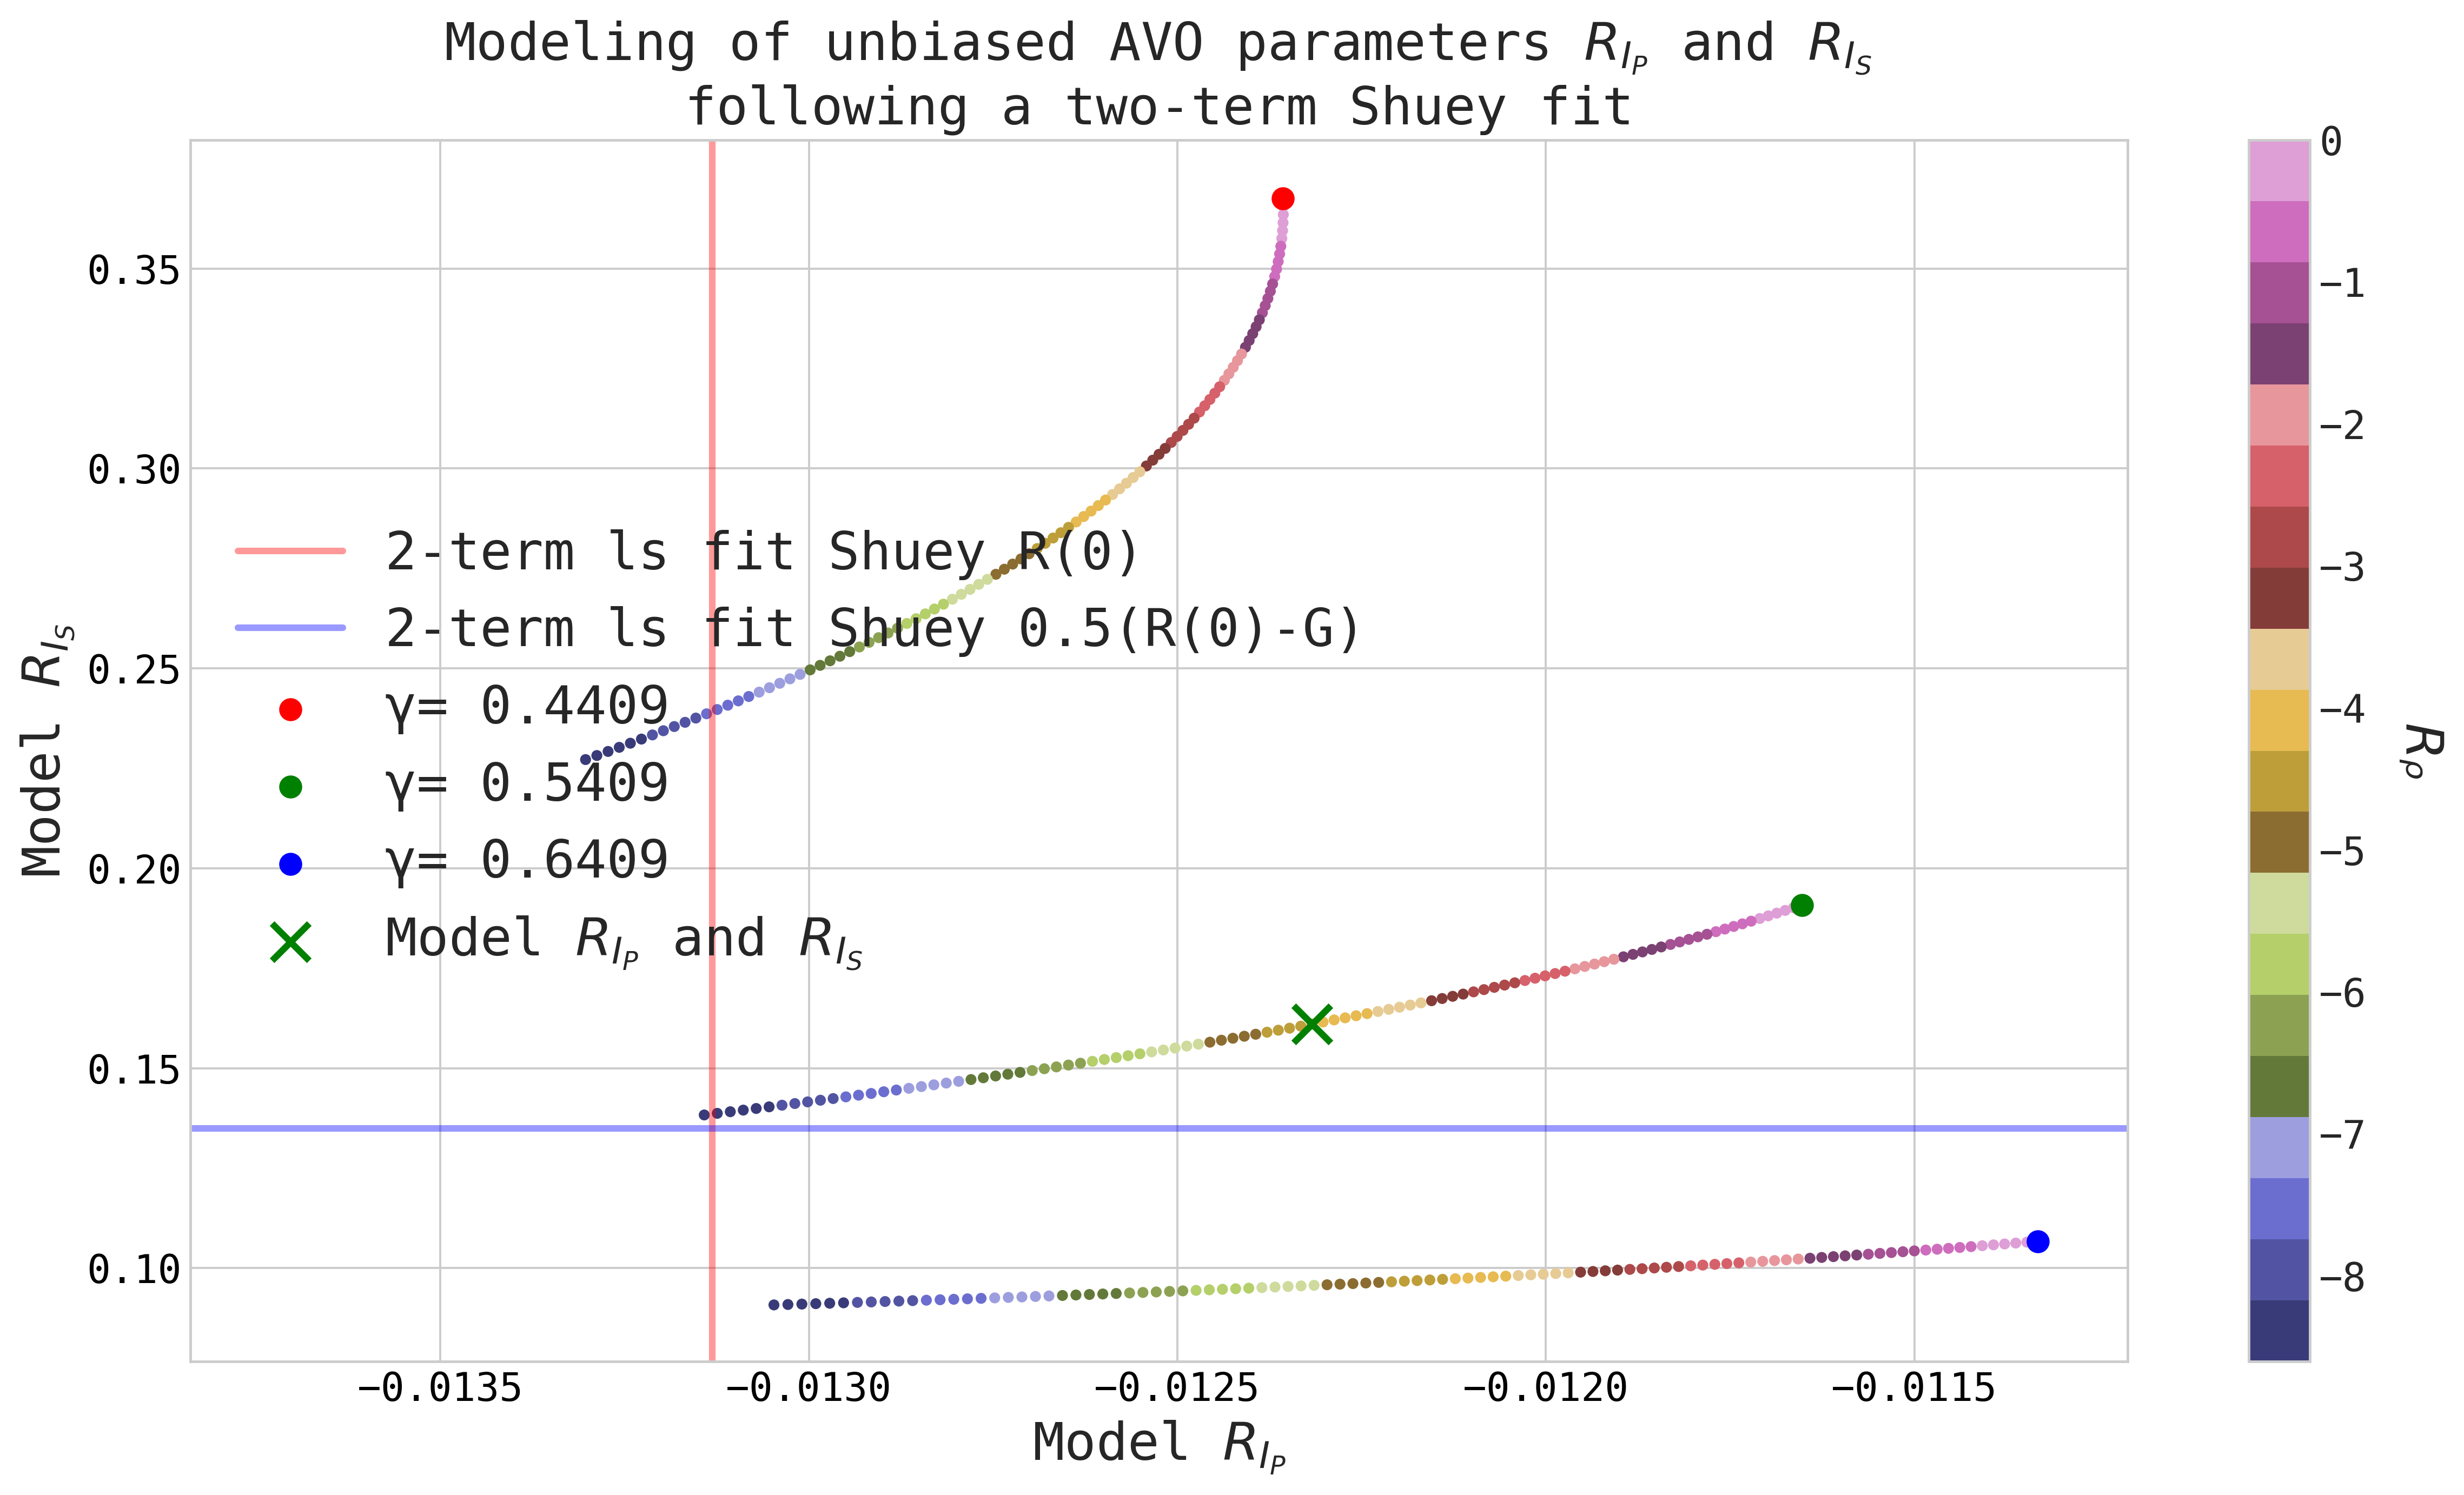

In [51]:
# Crossplot of RIp and RIs
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 350
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
#######################################
# Crossplots
plt.rcParams['axes.labelsize'] = 20
plt.rc('font',family='monospace')
fig, axs =plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(14, 8))
gcol  = np.zeros( (maxNgammas) )
gcol=['red', 'green', 'blue', 'orange']
# dk 
for k in range(0, Ngammas):
#    lab='g= %1.4f' %(gplay[k])
#    axs.scatter(quadTerms[0,k,:], quadTerms[1,k,:], c=gcol[k], s=3, marker='d', label=lab)
    resids=plt.scatter(quadTerms[0,k,:], quadTerms[1,k,:], s=10, c=cValue[k, :], cmap="tab20b")
    lab=''+gammauni+'= %1.4f' %(gplay[k])
    axs.scatter(quadTerms[0,k,0], quadTerms[1,k,0], c=gcol[k], s=60, marker='o', label=lab)
axs.scatter(RIp, RIs, c='green', s=200, marker='x', label='Model $R_{I_P}$ and $R_{I_S}$')
#axs.scatter(Model[0], Model[1], c='purple', s=200, marker='x', label='2-term ls fit Shuey')
#axs.scatter(Model3t[0], Model3t[1], c='red', s=200, marker='x', label='3-term ls fit Shuey')
##

axs.set_xlabel('Model $R_{I_P}$', fontsize=20)
axs.set_ylabel('Model $R_{I_S}$', fontsize =20)
axs.tick_params(axis='x', labelcolor='black', labelsize=15)
axs.tick_params(axis='y', labelcolor='black', labelsize=15)
###
axs.axvline(ModelShuey2t[0], color='red', alpha=0.4, label='2-term ls fit Shuey R(0)')
axs.axhline((ModelShuey2t[0]-ModelShuey2t[1])/2, color='blue', alpha=0.4, label='2-term ls fit Shuey 0.5(R(0)-G)')
clb=plt.colorbar(resids)
clb.set_label('$R\u1D68$', rotation=270, labelpad=+30, fontsize=20)
clb.ax.tick_params(labelsize=15)
#######
axs.set_title('Modeling of unbiased AVO parameters $R_{I_P}$ and $R_{I_S}$ \nfollowing a two-term Shuey fit', fontsize=20)
#
axs.legend(loc='best',fontsize=20)
fig.tight_layout()
#plt.savefig('TLEHoeber2021_Fig4right.jpg')
plt.show()

***Monte Carlo two-term fitting and add statistical error bars***

In [52]:
from numpy.linalg import inv
# for constrained fitting
from scipy.sparse import rand
from scipy.optimize import lsq_linear
def ARangle(minangle, maxangle, vp1, vp2):
    ##################################
    # Angles (regressor X)
    nangle   = maxangle - minangle + 1
    # X = the regressor 
    Angles= np.linspace(minangle, maxangle, nangle)
    theta  = np.radians(Angles)
    nangles = len(Angles) # number of observations
    theta2 = np.arcsin((vp2/vp1)*np.sin(theta))
    # Aki Richards is modelled with average angle
    avtheta = (theta+theta2)/2.0
    print('maxangle', maxangle)
    print('max average angle', np.degrees(avtheta[nangle-1]))
    return avtheta
def printAVOfit(R0, G , *args, **kwrags):
    #
    print('R0 = %f' % R0)
    print('G  = %f' % G)

    # Curvature too
    if args:
        for C in args:
            print('C  = %f' % C)
def printAVOStats(mean, st, nterms):
    #
    print ('Intercept = %f +/- %4.5f ' % (mean[0], st[0]))
    print ('Gradient  = %f +/- %4.5f ' % (mean[1], st[1]))
    if (nterms > 2):
        print ('Curvature  = %f +/- %4.5f ' % (mean[2], st[2]))
def AkiRichards(vp1, vs1, rho1, vp2, vs2, rho2):
    #
    # Model the AVO using Aki Richards 3 terms, as a function of average angle
    drho = rho2-rho1
    dvp = vp2-vp1
    dvs = vs2-vs1
    rho = (rho1+rho2)/2.0
    vp = (vp1+vp2)/2.0
    vs = (vs1+vs2)/2.0
    dr = drho/rho
    # Calculate R0, G, C
    R0 = 0.5*(dvp/vp + dr)
    np.set_printoptions(precision=4)
    print('Aki Richards R0', R0)
    Grad = 0.5 * dvp/vp - 2 * (vs/vp)**2  *(dr + 2* dvs/vs)
    print('Aki Richards Grad', Grad)
    Curv = 0.5 * dvp/vp
    print('Aki Richards Curvature', Curv)
    print('---------------------------------')
    return (R0, Grad, Curv)
def AVOAnalysis(vp1, vs1, rho1, vp2, vs2, rho2, nmodelpar, nfitpar, minangle, maxangle, randomseed):
    # Does Monte Carlo noise analysis for 2 or 3 term fit (nfitpar = 2, 3)
    # if niftpar is coded as 4, we do a constrained 3 term fit based on a 2 term fit
    # where the 2 term fit is in a limited angle range
    # In that case care needs to be taken with the noise so that it's correlated.
    reducedangle = 25
    if(nfitpar < 4): reducedangle = maxangle
    ##################################
    # Model with 3 term Aki Richards
    ##################################
    R0, Grad, Curv = AkiRichards(vp1, vs1, rho1, vp2, vs2, rho2)        
    C=0.0
    if(nmodelpar > 2):C  = Curv
    if(nmodelpar< 3): print('Using a 2-term model, so curvature from fits should be 0!')
    print('Model input params are:')
    if(nmodelpar> 2): print('Model has curvature component')
    printAVOfit(R0, Grad, C)
    ##################################
    # get average angle in radians
    avtheta = ARangle(minangle, maxangle, vp1, vp2)
    nangle   = len(avtheta)
    X  = np.sin(avtheta)**2
    sin2reducedangle = math.sin(math.radians(reducedangle))**2
    Xmaxsin2 = math.sin(avtheta[nangle-1])**2
    print('Max sin^2 is', Xmaxsin2)
    if(nfitpar > 2):
        X2 = np.tan(avtheta)**2 - np.sin(avtheta)**2
        X3 = np.cos(avtheta) * np.sin(avtheta)**2
        if(nfitpar>3):
            # in this case we need to define a narrow angle range for the first 2 term fit
            Xin =X[X < sin2reducedangle]  #np.sin(avtheta[0:nangle-reduce])
            nreducedangle = len(Xin)
            print('nreducedangle = %d' % nreducedangle)
            print('Performing reduced angle 2 term fit followed by 3 term fit')
            maxavangle = math.degrees(avtheta[len(Xin)-1])
            print('Max angle for 2 term fit is %f' % maxavangle)
            Xin = np.sin(Xin)**2
    # if nfitpar=2 or 3, I have a quick hack here to set the max angle back to where it should be
    if(nfitpar < 4): nreducedangle = len(X)
    # Now carry on as normal
    ran = np.random.normal(size=nangle)
    #
    Y_clean = R0 + Grad * X + C * X2 + X3 *(C - G)**2 * 1/(4*gamma)
    modelData[:,0]=Y_clean[:]
    # Noise variance
    sdy = Y_clean - Y_clean + sd
    # add X dependent error term to y for heterscdasticity
    sdy = sdy + het * X
    # 2 term fit results
    fit2Termsf =np.zeros( (2, noiseRealisations) )
    fit2Termsr =np.zeros( (2, noiseRealisations) )
    # 3 term fit results
    fit3Terms =np.zeros( (3, noiseRealisations) )
    # Constrained 3 term fit results
    fit3CTerms =np.zeros( (3, noiseRealisations) )
    # Design matrices for 2 and 3 term fits
    Afull = np.column_stack( (np.ones(nangle), X ))
    #print(Afull.shape)
    # 2 term fit either over full angle range (nfitpar=2) or reduced (nfitpar=4)
    Ared = Afull[0: nreducedangle, 0:2]
    Aquad = np.column_stack( (np.ones(nangle),X, X2 )) 
    # solve both 2 and 3 term inversion
    ATAfull = np.dot(Afull.transpose(),Afull)
    ATAINVfull = np.linalg.inv(ATAfull)
    ATAred = np.dot(Ared.transpose(),Ared)
    ATAINVred = np.linalg.inv(ATAred)
    ATAquad = np.dot(Aquad.transpose(),Aquad)
    ATAINV1 = np.linalg.inv(ATAquad)
    # Calculate bias weights
    ## Matrix to calculate bias in full angle range partial regression
    A2full = np.column_stack(X2)
    ATA2full = np.dot(Afull.transpose(),A2full.transpose())
    #print(ATA2)
    BiasFull = np.dot(ATAINVfull, ATA2full)
    print ('BiasFull= ', BiasFull)
    #
    # Loop over noise realisations and run the fits
    #
    for j in range(noiseRealisations):
        Errory = sdy * np.random.normal(size=nangle)
        Y_noisy = Y_clean + Errory
        modelData[:,1+j]=Y_noisy[:]
        # 2 term fit over full angle range
        ATYf = np.dot(Afull.transpose(),Y_noisy)
        fit2Termsf[:,j] = np.dot(ATAINVfull,ATYf)
        # 2 term fit over full angle range or reduced if preparing for constrained 3 term fit
        ATYr = np.dot(Ared.transpose(),Y_noisy[0:nreducedangle])
        fit2Termsr[:,j] = np.dot(ATAINVred,ATYr)
        # 3 term fit over full angle range
        ATY1 = np.dot(Aquad.transpose(),Y_noisy)
        fit3Terms[:,j] = np.dot(ATAINV1,ATY1) 
    #
    print('Model input params are:')
    if(nmodelpar> 2): print('Model has curvature component')
    printAVOfit(R0, Grad, C)
    print('2 term fit in range', avtheta[0], math.degrees(avtheta[nreducedangle-1]))
    av2Termsr  = np.mean(fit2Termsr, axis=1)
    var2Termsr =  np.sqrt(np.var(fit2Termsr, axis=1))
    printAVOStats(av2Termsr, var2Termsr,2)
    print('2 term fit in range', avtheta[0], math.degrees(avtheta[nangle-1]))
    av2Termsf  = np.mean(fit2Termsf, axis=1)
    var2Termsf =  np.sqrt(np.var(fit2Termsf, axis=1))
    printAVOStats(av2Termsf, var2Termsf,2)
    # 3 term fit
    print('3 term fit in range', avtheta[0], math.degrees(avtheta[nangle-1]))
    av3Terms  = np.mean(fit3Terms, axis=1)
    var3Terms =  np.sqrt(np.var(fit3Terms, axis=1))
    printAVOStats(av3Terms, var3Terms,3)
    #
    # BOXPLOTS
    # R0 
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    axs[0].boxplot(fit2Termsf[0,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[0].set_title('R0 from a 2-parameter fit')
    axs[1].boxplot(fit2Termsr[0,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[1].set_title('reduced angles')
    axs[2].boxplot(fit3Terms[0,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[2].set_title('3-parameter fit')
    axs[0].axhline(R0, color='k', alpha=0.4)
    axs[1].axhline(R0, color='k', alpha=0.4)
    axs[2].axhline(R0, color='k', alpha=0.4)
    y_min, y_max = axs[2].axes.get_ylim()
    #y_min = 0.063
    #y_max = 0.084
    axs[0].set_ylim(y_min, y_max)
    axs[2].set_ylim(y_min, y_max)
    axs[1].set_ylim(y_min, y_max)
    fig.tight_layout()
    plt.show()
    if(nmodelpar< 3): print('Model has zero curvature component')
    if(nmodelpar> 2): print('Model has curvature component')
    print('R0 model = %f' % R0)
    # G
    #
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    axs[0].boxplot(fit2Termsf[1,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[0].set_title('G from a 2-parameter fit')
    axs[1].boxplot(fit2Termsr[1,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[1].set_title('reduced angles')
    axs[2].boxplot(fit3Terms[1,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[2].set_title('3-parameter fit')
    axs[0].axhline(Grad, color='k', alpha=0.4)
    axs[1].axhline(Grad, color='k', alpha=0.4)
    axs[2].axhline(Grad, color='k', alpha=0.4)
    fig.tight_layout()
    y_min, y_max = axs[2].axes.get_ylim()
    #y_min = -0.35
    #y_max = -0.05
    axs[0].set_ylim(y_min, y_max)
    axs[2].set_ylim(y_min, y_max)
    axs[1].set_ylim(y_min, y_max)
    plt.show()
    if(nmodelpar< 3): print('Model has no curvature component')
    if(nmodelpar> 2): print('Model has curvature component')
    print('G model  = %f' % Grad)
    # C
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    axs[2].boxplot(fit3Terms[2,:], showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'red'})
    axs[2].set_title('Curvature from a 3-parameter fit')
    fig.tight_layout()
    axs[2].axhline(C, color='k', alpha=0.4)
    y_min, y_max = axs[0].axes.get_ylim()
    y_min = -0.15
    y_max = 0.3
    axs[2].set_ylim(y_min, y_max)
    plt.show()
    if(nmodelpar< 3): print('Model has no curvature component')
    if(nmodelpar> 2): print('Model has curvature component as shown')
    print('C model  = %f' % C)
    #
    # Crossplots
    #
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(22, 9))
    #
    # R0-G
    axs[0][0].scatter(fit2Termsf[0,:], fit2Termsf[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    axs[0][1].scatter(fit2Termsr[0,:], fit2Termsr[1,:], c='black', s=10, marker='d', label='reduced angle 2-term R0-G')
    axs[0][2].scatter(fit3Terms[0,:],  fit3Terms[1,:], c='black', s=10, marker='d', label='3-term R0-G')
    y_min, y_max = axs[0][1].axes.get_ylim()
    x_min, x_max = axs[0][1].axes.get_xlim()
    axs[0][0].set_title('2-parameter fit', fontsize=25)
    axs[0][1].set_title('reduced angle 2-parameter fit', fontsize=25)
    axs[0][2].set_title('3-parameter fit', fontsize = 25)
    for ax in (axs[0][:]):
        ax.scatter(R0, Grad, c='red', s=100, marker='d')
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(x_min, x_max)
        ax.set_xlabel('R0', fontsize=20)
        ax.set_ylabel('G', fontsize =20)
        ax.tick_params(axis='x', labelcolor='black', labelsize=15)
        ax.tick_params(axis='y', labelcolor='black', labelsize=15)
    #
    # G-C
    axs[1][2].scatter(fit3Terms[1,:], fit3Terms[2,:], c='black', s=10, marker='d', label='3-term G-C')
    y_min1, y_max1 = axs[1][2].axes.get_ylim()
    x_min1, x_max1 = axs[1][2].axes.get_xlim()
    axs[1][2].set_title('3-parameter fit', fontsize = 25)
    for ax1 in (axs[1][0:3]):
        ax1.scatter(Grad, C,  c='red', s=100, marker='d')
        ax1.set_ylim(y_min1, y_max1)
        ax1.set_xlim(x_min1, x_max1)
        ax1.set_xlabel('G', fontsize=20)
        ax1.set_ylabel('C', fontsize =20)
        ax1.tick_params(axis='x', labelcolor='black', labelsize=15)
        ax1.tick_params(axis='y', labelcolor='black', labelsize=15)
    fig.tight_layout()
    plt.show()
    #
    # What about about fluid and lithology?
    #
    # Crossplots 
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(22,9))
    # krho and murho 5R0+G vs 2R0 - 2G
    axs[0][0].scatter(5*fit2Termsf[0,:] + fit2Termsf[1,:], 2*fit2Termsf[0,:] - 2*fit2Termsf[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    axs[0][1].scatter(5*fit2Termsr[0,:] + fit2Termsr[1,:], 2*fit2Termsr[0,:] - 2*fit2Termsr[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    axs[0][2].scatter(5*fit3Terms[0,:]  + fit3Terms[1,:],  2*fit3Terms[0,:]  - 2*fit3Terms[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    y_min, y_max = axs[0][1].axes.get_ylim()
    x_min, x_max = axs[0][1].axes.get_xlim()
    axs[0][0].set_title('2-parameter fit', fontsize=25)
    axs[0][1].set_title('reduced angle 2-parameter fit', fontsize=25)
    axs[0][2].set_title('3-parameter fit', fontsize = 25)
    for ax in (axs[0][:]):
        ax.scatter(5*R0+Grad, 2*R0 - 2*Grad, c='red', s=100, marker='d')
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(x_min, x_max)
        ax.set_xlabel('k*rho', fontsize=30)
        ax.set_ylabel('mu*rho', fontsize =30)
        ax.tick_params(axis='x', labelcolor='black', labelsize=25)
        ax.tick_params(axis='y', labelcolor='black', labelsize=25)
    #
    # lambda rho and murho 3R0+G vs 2R0 - 2G
    axs[1][0].scatter(3*fit2Termsf[0,:] + fit2Termsf[1,:], 2*fit2Termsf[0,:] - 2*fit2Termsf[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    axs[1][1].scatter(3*fit2Termsr[0,:] + fit2Termsr[1,:], 2*fit2Termsr[0,:] - 2*fit2Termsr[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    axs[1][2].scatter(3*fit3Terms[0,:]  + fit3Terms[1,:],  2*fit3Terms[0,:]  - 2*fit3Terms[1,:], c='black', s=10, marker='d', label='2-term R0-G')
    y_min, y_max = axs[1][1].axes.get_ylim()
    x_min, x_max = axs[1][1].axes.get_xlim()
    axs[1][0].set_title('2-parameter fit', fontsize=25)
    axs[1][1].set_title('reduced angle 2-parameter fit', fontsize=25)
    axs[1][2].set_title('3-parameter fit', fontsize = 25)
    for ax in (axs[1][:]):
        ax.scatter(3*R0+Grad, 2*R0 - 2*Grad, c='red', s=100, marker='d')
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(x_min, x_max)
        ax.set_xlabel('lambda*rho', fontsize=30)
        ax.set_ylabel('mu*rho', fontsize =30)
        ax.tick_params(axis='x', labelcolor='black', labelsize=25)
        ax.tick_params(axis='y', labelcolor='black', labelsize=25)
    fig.tight_layout()
    plt.show()
    return (modelData, fit2Termsf, fit2Termsr, fit3Terms, BiasFull)

<font color=red> 
**User choice: standard deviation of random noise.**
 </font>  

In [53]:
############################### INPUT PARAMS in this box
#
# Noise mean and standard devs for Y (default is 0 and 0.005)
# Note I model heteroscedastic noise, but no outliers (het default 0.01)
mu=0
sd=0.01
het=0.00
# random noise
np.random.seed(1)
# how many noise realisations (default 1000)
noiseRealisations = 2000
# Choose if Aki Richards is modelled with 2 or 3 terms (default is 3)
nmodelpar=3
# Input min and max angle (eg 0 to 30 degrees)
# Note max angle can be larger due to average angle being used in Aki Richards
# Choose fitting method nfitpar
# setting it to 2 or 3 should run a 2 and 3 term fit and a constrained 3-term using Gardner all on full angle range
# setting it to 4 should run a 2-term fit on a reduced angle range, then a 3 term and constrained 3-term on full range
nfitpar = 4

## Extra figure
Create boxpots of the Monte-Carlo fit results and generate some AVO crossplots.
I've added the crossplots here; they will come in handy, when we want to look at more realistic modelling and log-data analysis.

Aki Richards R0 -0.012317338495537344
Aki Richards Grad -0.4033494504671502
Aki Richards Curvature 0.07063197026022305
---------------------------------
Model input params are:
Model has curvature component
R0 = -0.012317
G  = -0.403349
C  = 0.070632
maxangle 35
max average angle 38.17893233449576
Max sin^2 is 0.3820715850878664
nreducedangle = 24
Performing reduced angle 2 term fit followed by 3 term fit
Max angle for 2 term fit is 24.875764
BiasFull=  [[-0.0227]
 [ 0.5067]]
Model input params are:
Model has curvature component
R0 = -0.012317
G  = -0.403349
C  = 0.070632
2 term fit in range 0.0 24.875764148100753
Intercept = -0.012380 +/- 0.00315 
Gradient  = -0.294727 +/- 0.03799 
2 term fit in range 0.0 38.17893233449576
Intercept = -0.013079 +/- 0.00255 
Gradient  = -0.283298 +/- 0.01401 
3 term fit in range 0.0 38.17893233449576
Intercept = -0.012222 +/- 0.00306 
Gradient  = -0.302459 +/- 0.03928 
Curvature  = 0.037817 +/- 0.07164 


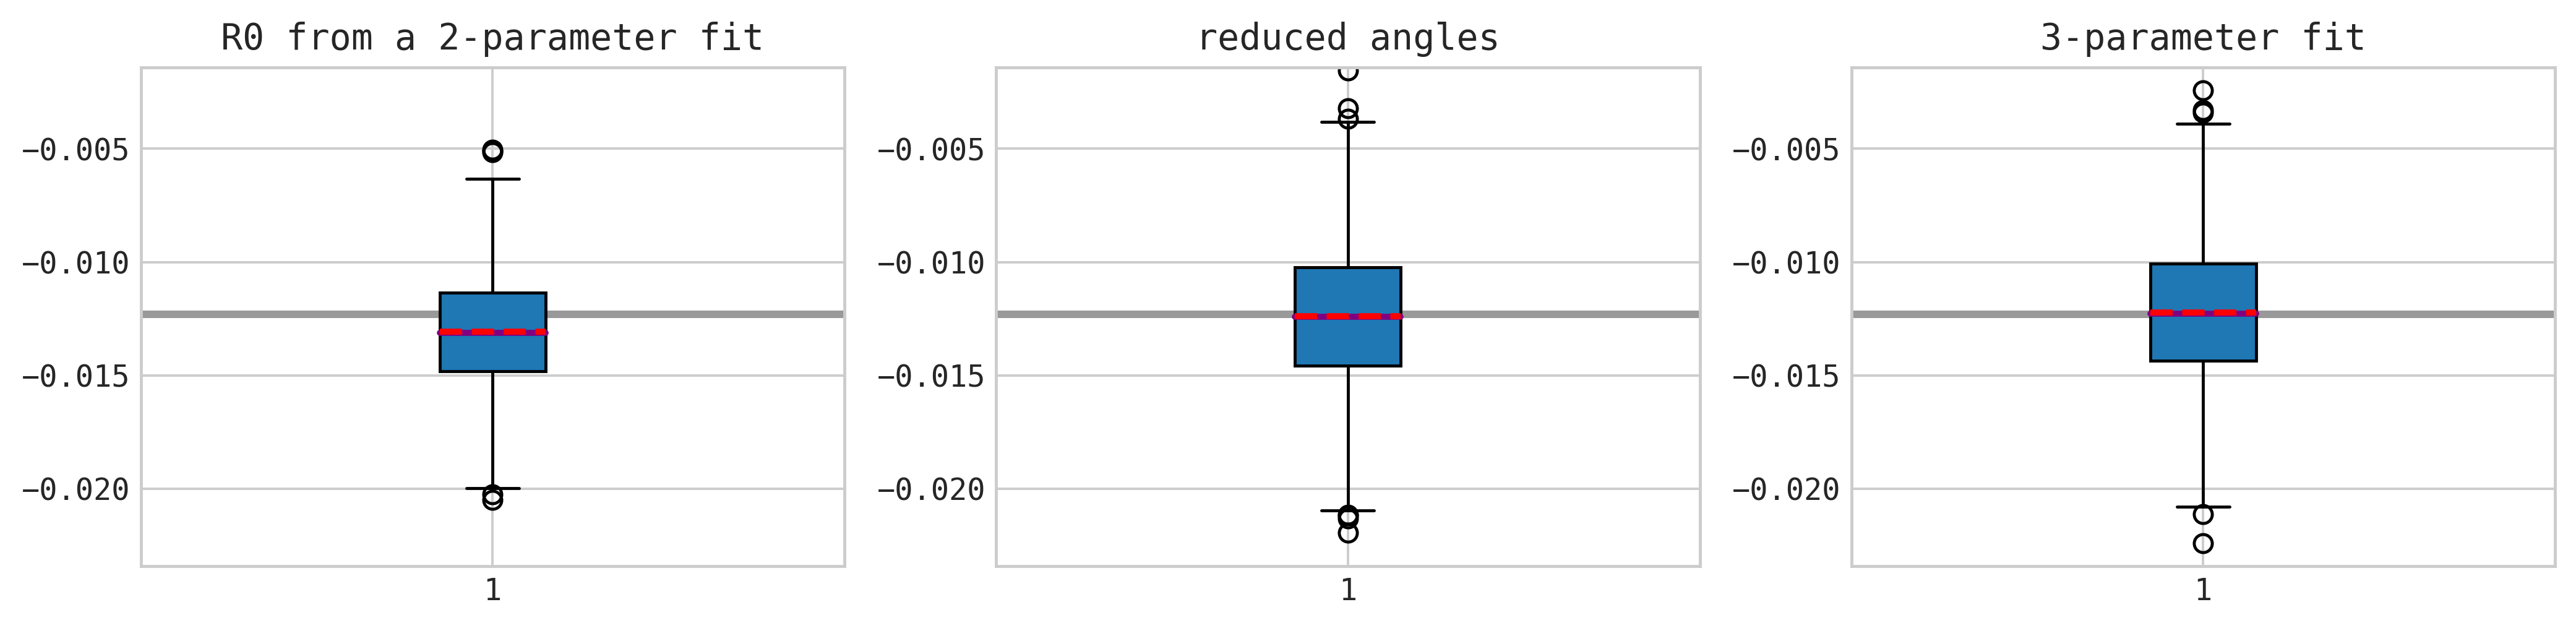

Model has curvature component
R0 model = -0.012317


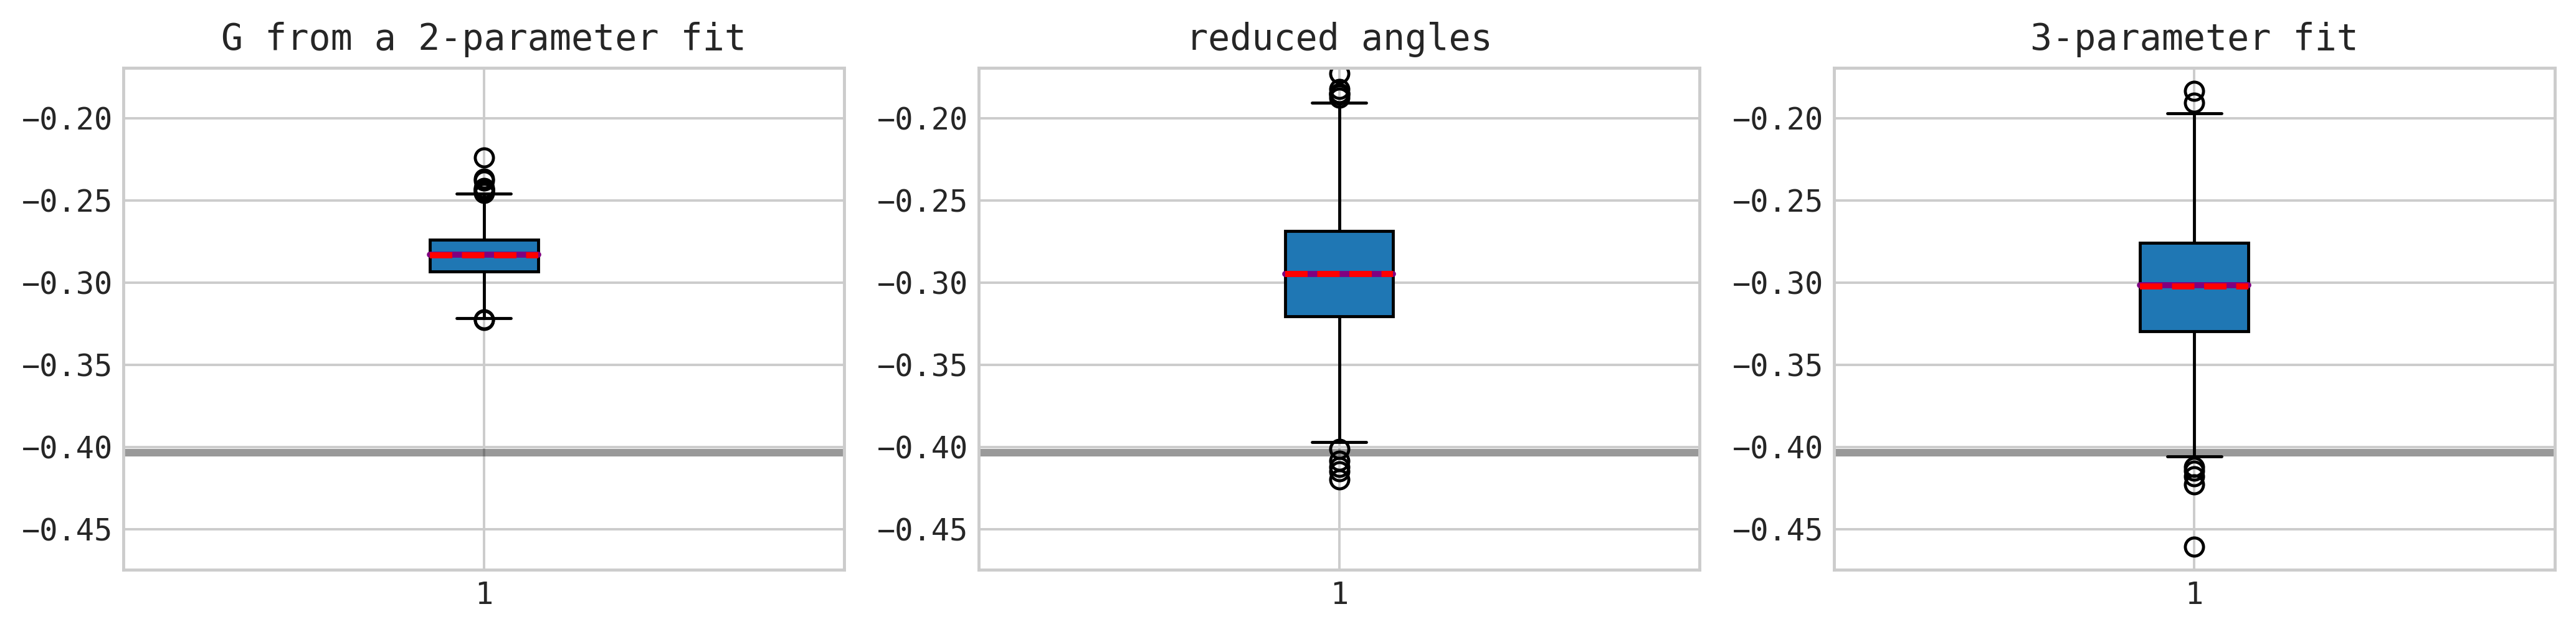

Model has curvature component
G model  = -0.403349


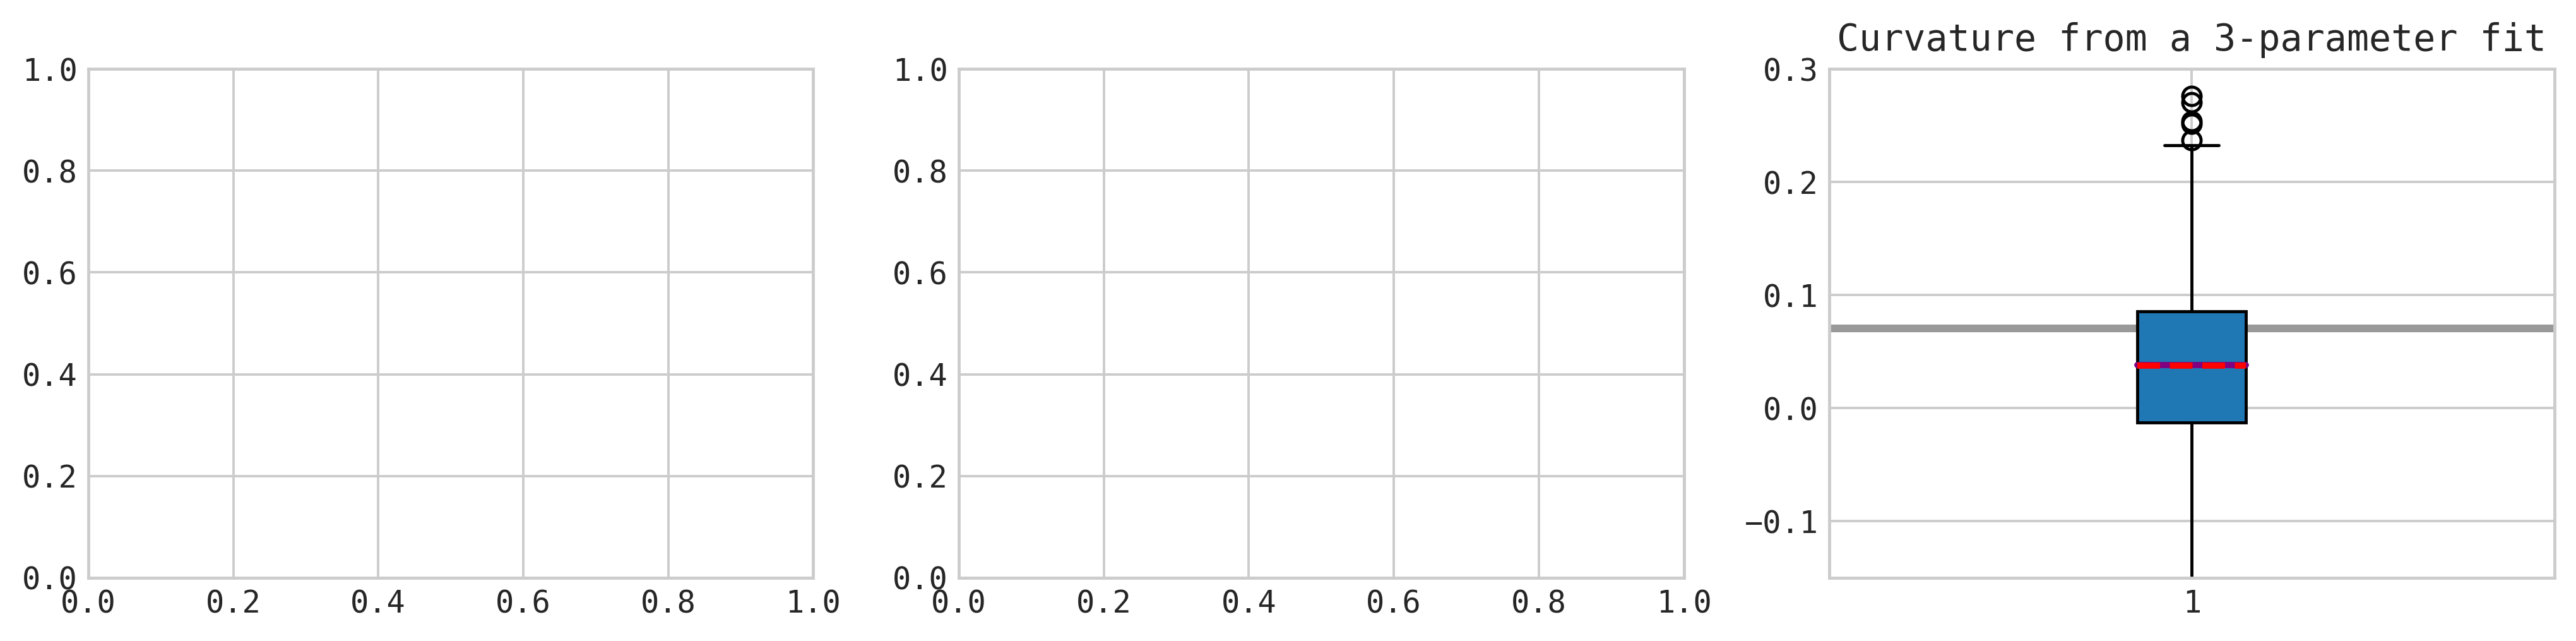

Model has curvature component as shown
C model  = 0.070632


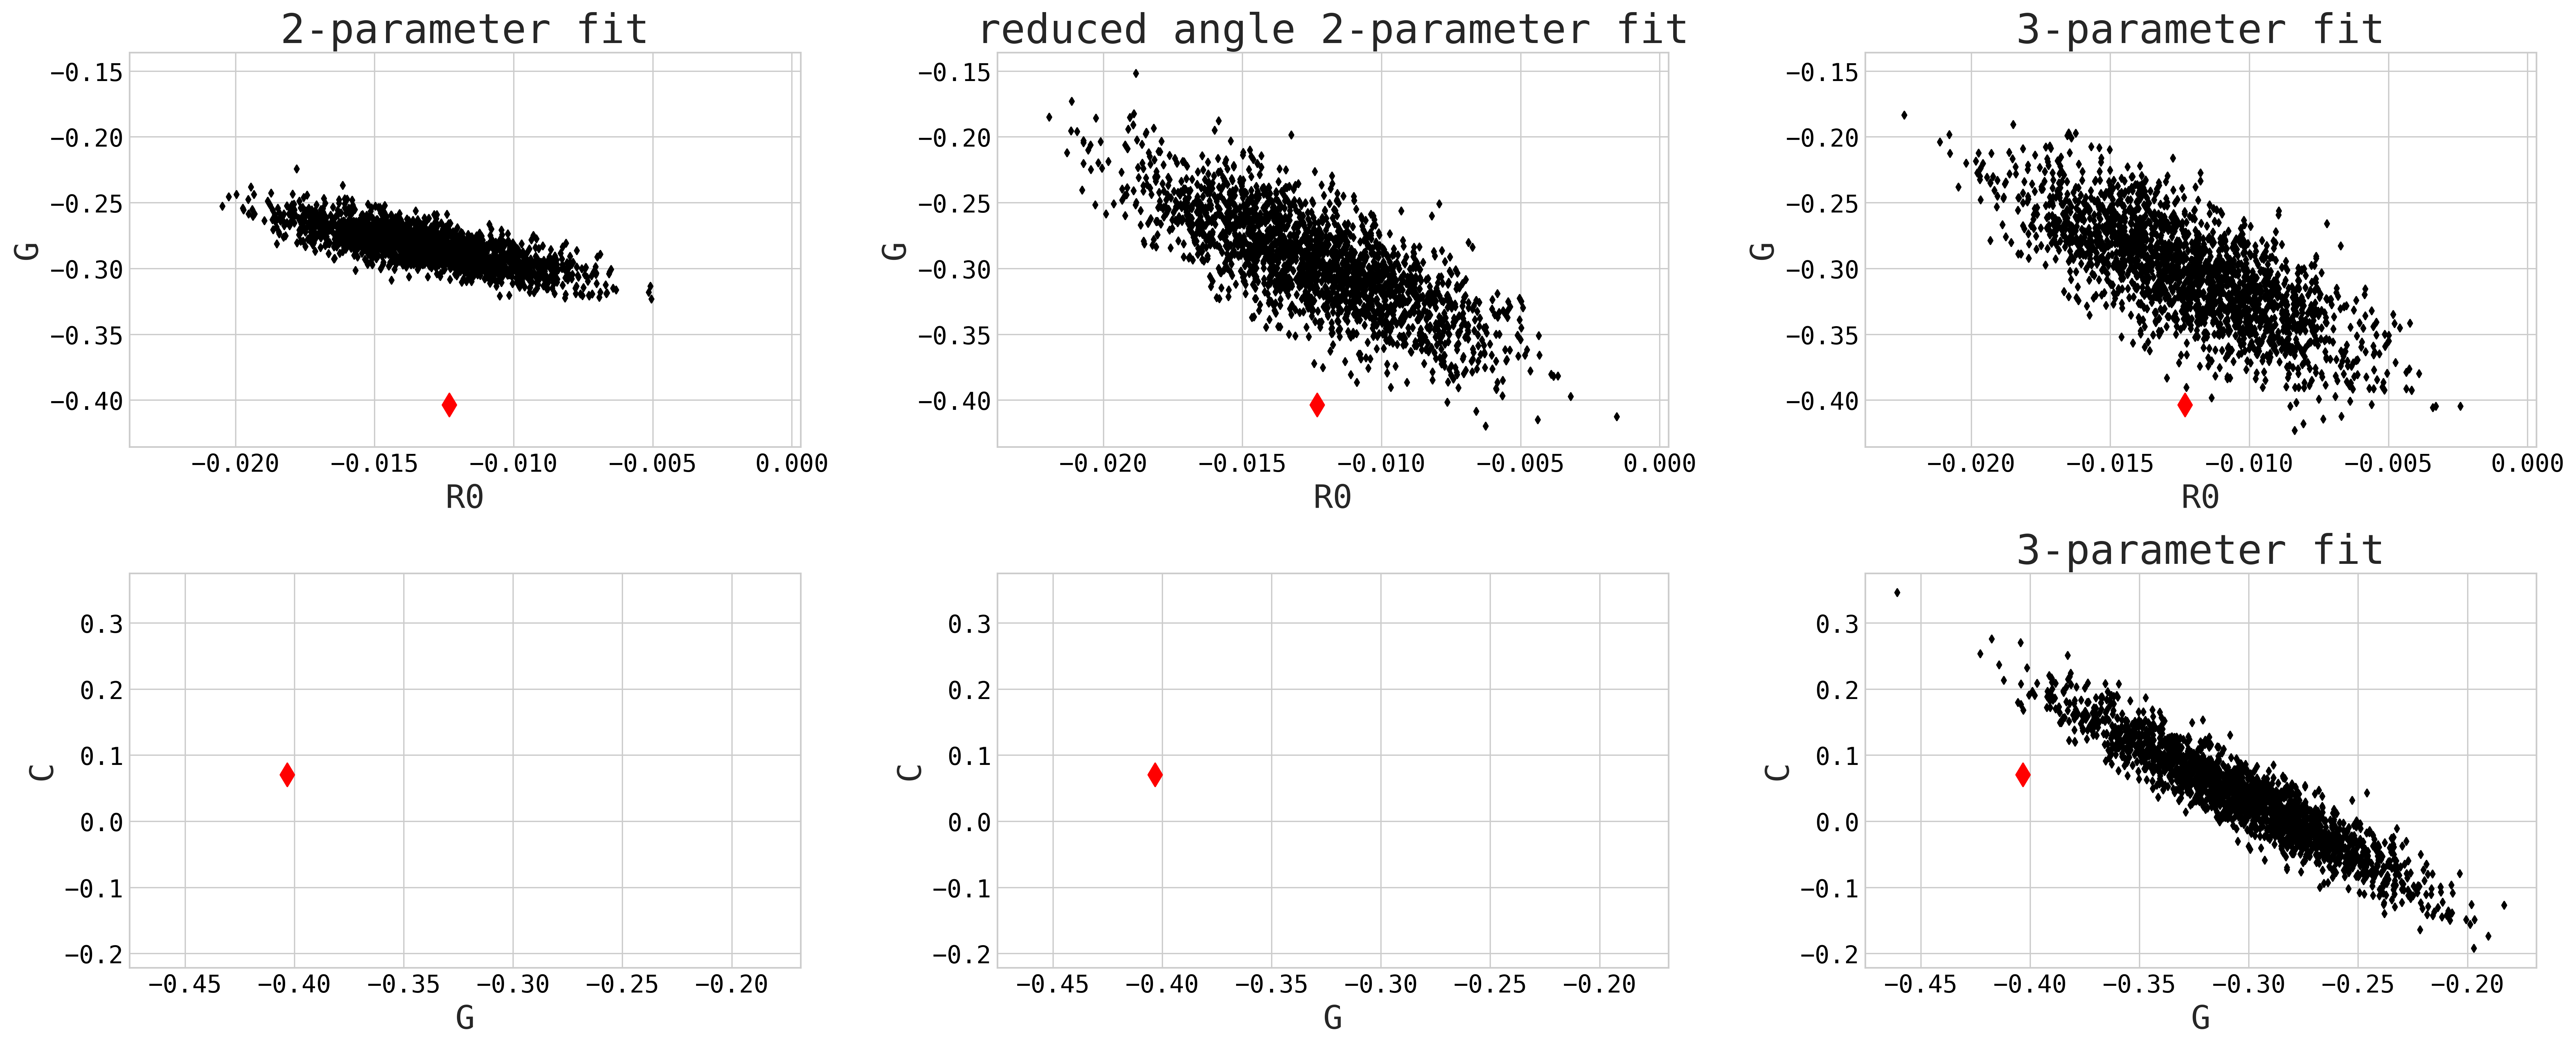

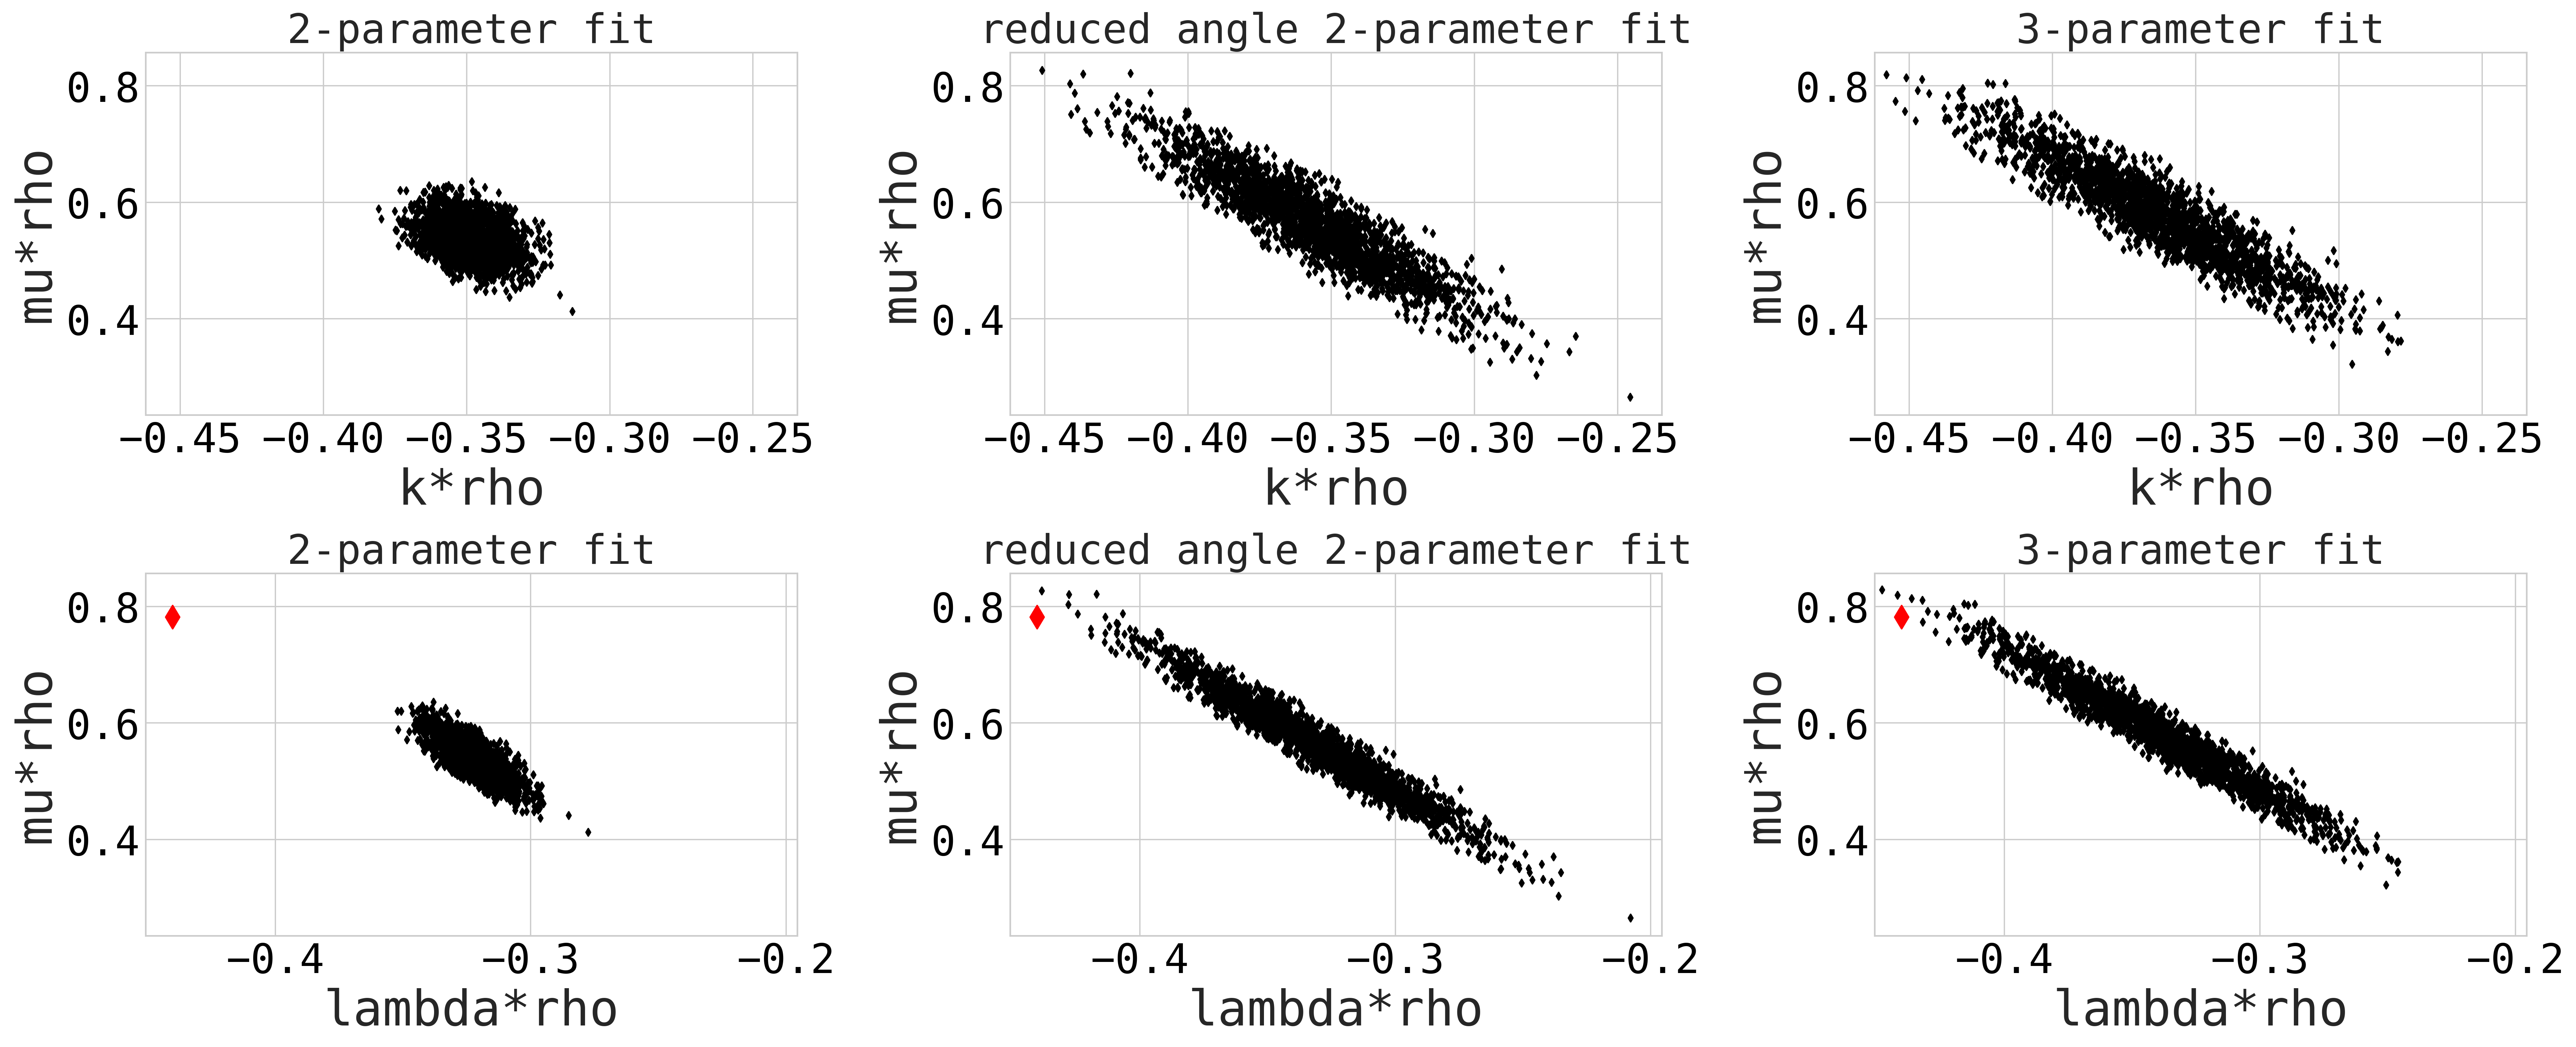

In [54]:
modelData =np.zeros( (nangle, noiseRealisations+1) )
modelData, fit2Termsf, fit2Termsr, fit3Termsf,  BiasFull = AVOAnalysis(vp1, vs1, rho1, vp2, vs2, rho2, nmodelpar, nfitpar, minangle, maxangle, 1)

In [55]:
from scipy.optimize import fsolve
#####################
#####################
def equations(vars, *args):
            # solve unbiased = biased - Bias3[0] - BiasQ[0]
            #Bias3 = Bias[:,0]*c*R0
            #BiasQ = Bias[:,1] (cR0-G)**2 / (4*gamma)
            # ModelDeb = Model - Bias3 - BiasQ
            # inputs are the measured two-term fit values hat R(0) and hat G
            # outputs, if c and gamma are correct are fully debiased Shuey parameters (R0,G)
            R0,G = vars
            c, g, Bias, R0hat, Ghat  = args
            ## equation 1 is for the biased R(0)
            ## equation 2 is for the biased G
            eq1 = R0 - R0hat + Bias[0,0]*c*R0 + Bias[0,1]* (c*R0 - G)**2 /(4*g)
            eq2 = G  - Ghat  + Bias[1,0]*c*R0 + Bias[1,1]* (c*R0 - G)**2 /(4*g)
            return (eq1, eq2)
Ngammas    = 4
maxNgammas = 4
cValue  =np.zeros( (Ngammas, 101) )
gplay  = np.zeros( (Ngammas) )
quadTerms =np.zeros( (2, Ngammas, 101) )
# Loop over possible c values
cmin = 0
cmax = 1.5*C/R0
dc = (cmax - cmin)/100
# loop over 3 gamma values
gplay[0] = gamma - 0.1
gplay[1] = gamma
gplay[2] = 1
gplay[3] = 1000
#########################
for k in range(0, Ngammas):
    c = cmin
    g = gplay[k]
    for j in range(0, 101):
        #####################
        p = (c, g, Bias, ModelShuey2t[0], ModelShuey2t[1])
        R0i, Gi =  fsolve(equations, (0.1, 0.1), p )
        ######################
        #print('Inverted model values post orthogonal fit =', R0i, Gi)  
        quadTerms[0,k,j]=R0i
        quadTerms[1,k,j]=Gi
        cValue[k, j] = c
        c = c + dc
    #print(g)
    ##
#print(cValue)

## Figure 5
Below I also plot the model AVO curve, and the noise realisations.

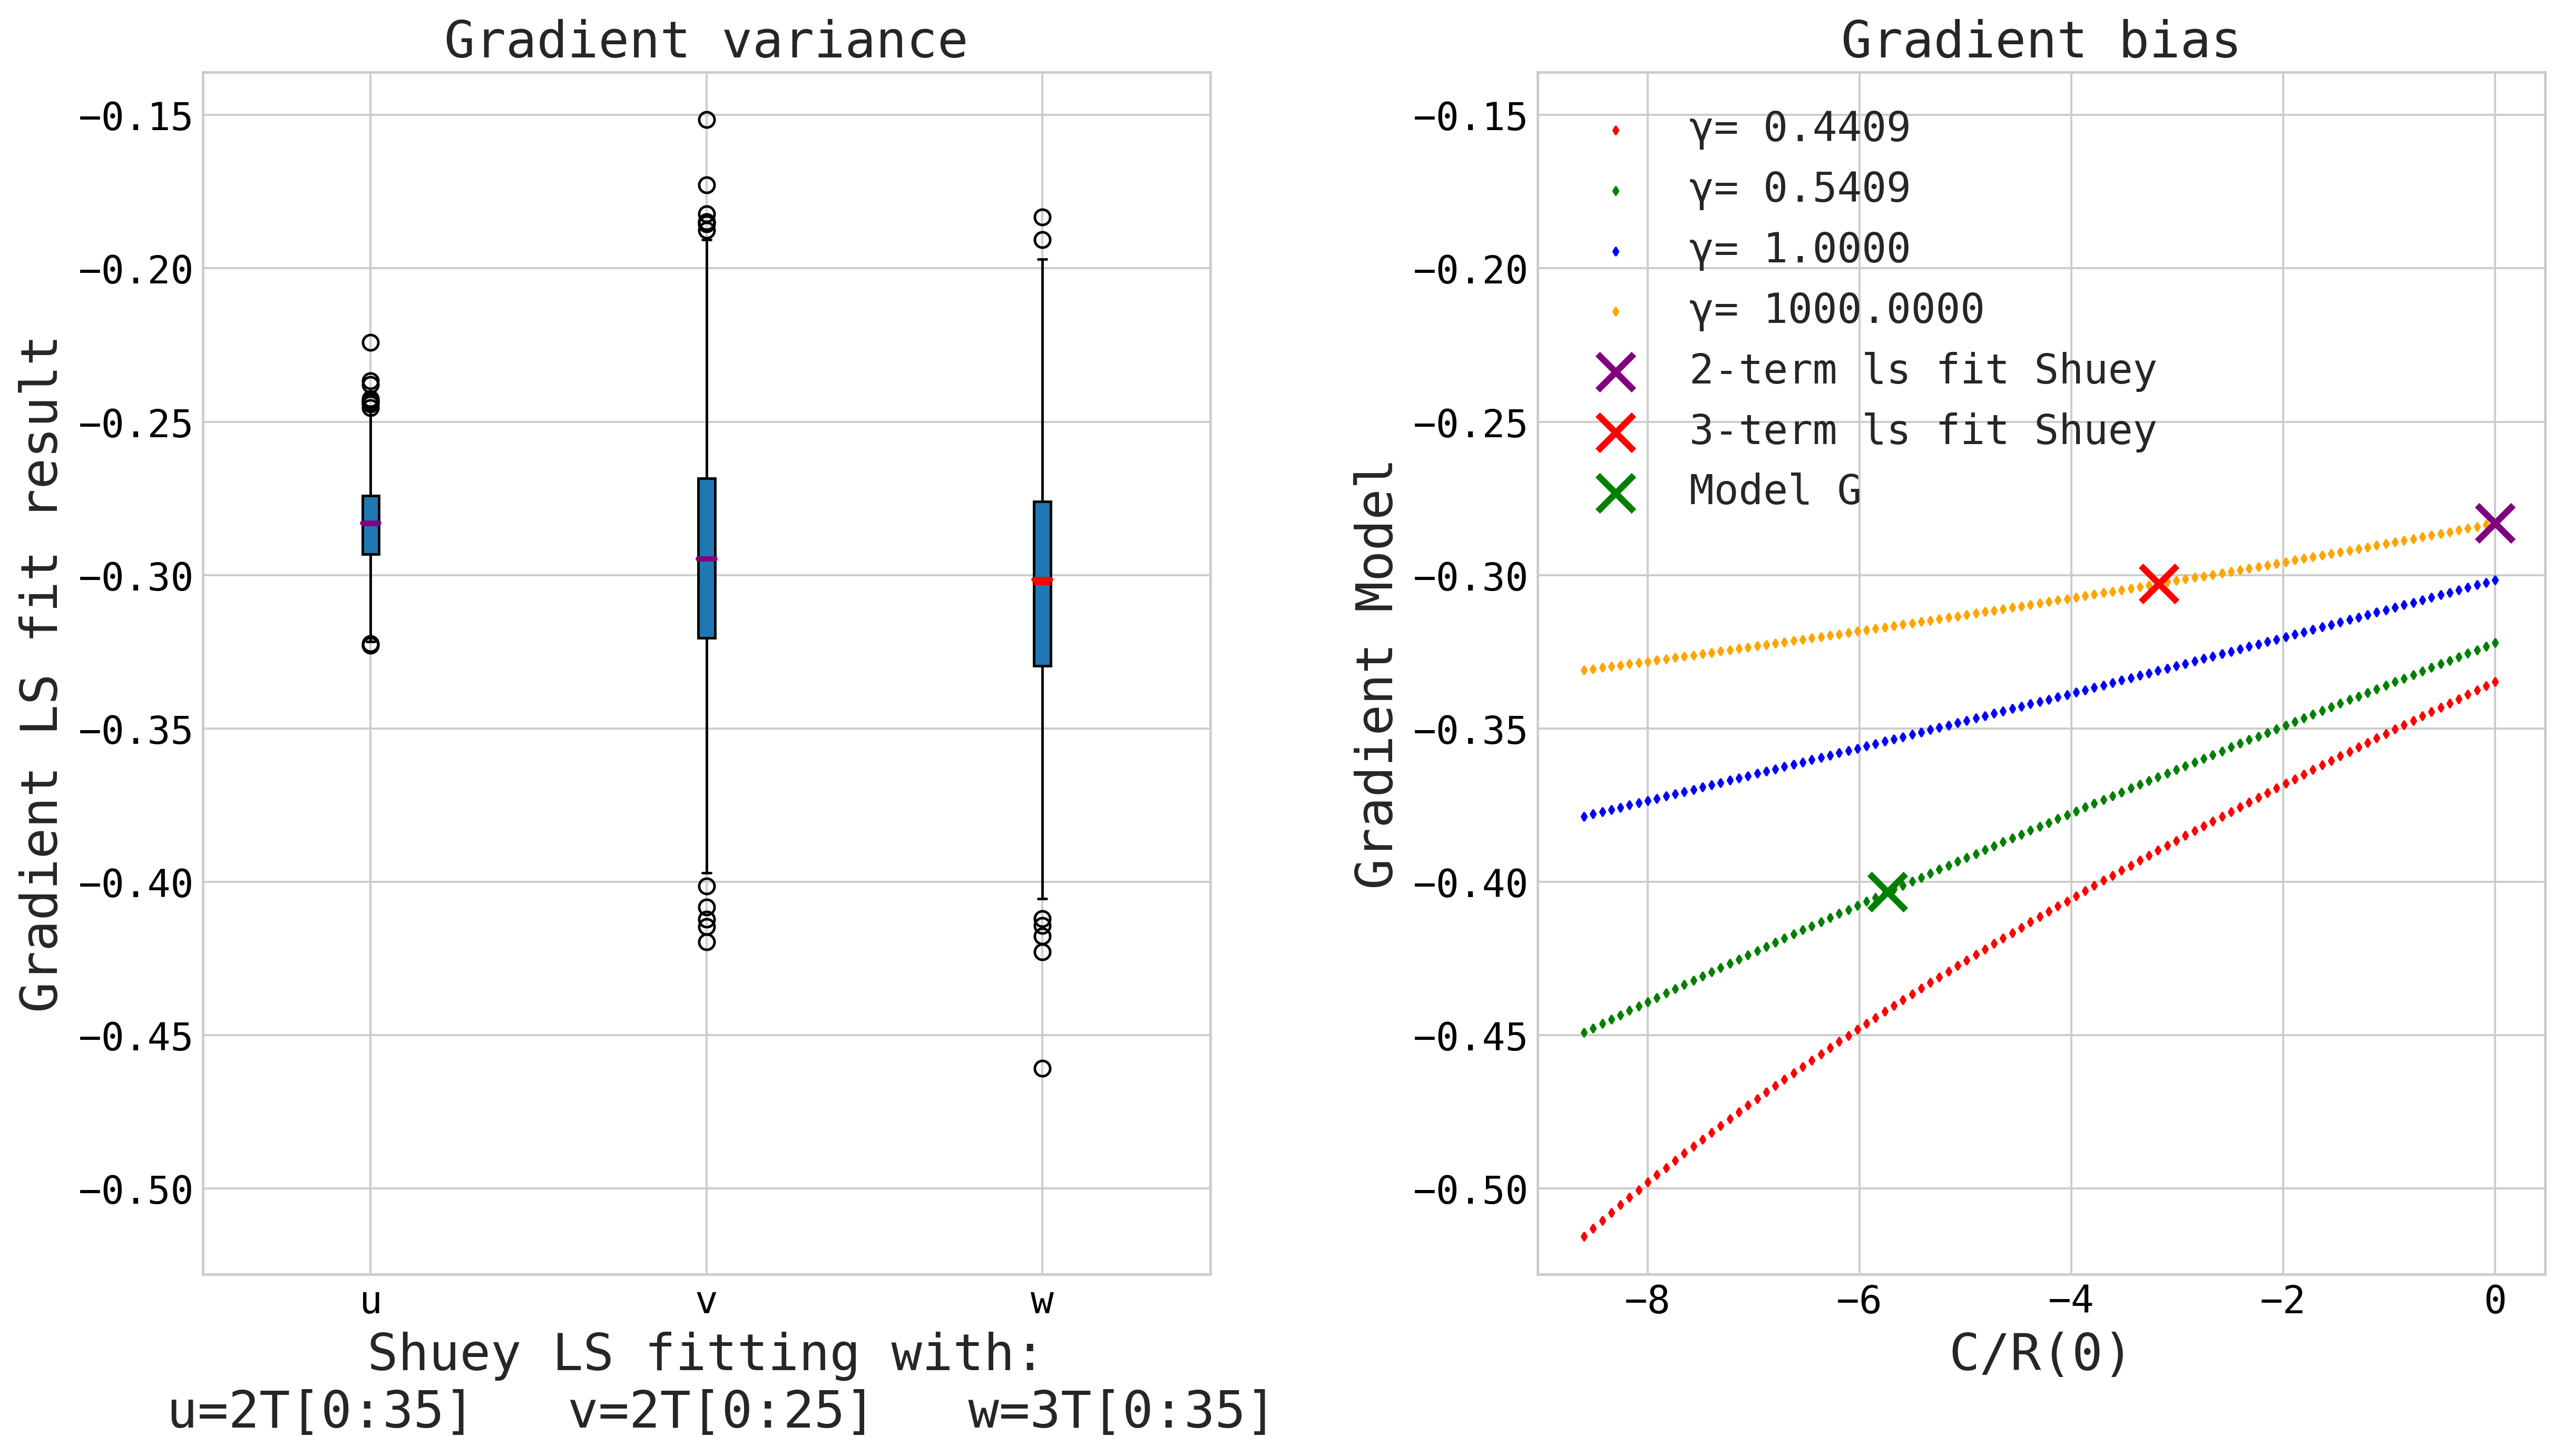

In [56]:
#######################################
plt.rcParams['axes.labelsize'] = 20
plt.rc('font',family='monospace')
fig, axs =plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14, 8))
gcol  = np.zeros( (maxNgammas) )
gcol=['red', 'green', 'blue', 'orange']
#### boxplot for gradient 2 term fit
axs[0].boxplot(fit2Termsf[1,:],labels='u',positions=[1],widths=0.05,showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'purple'})
axs[0].boxplot(fit2Termsr[1,:],labels='v',positions=[2],widths=0.05,showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'purple'},
               meanprops={'linewidth': 2, 'color': 'purple'})
axs[0].boxplot(fit3Termsf[1,:],labels='w',positions=[3],widths=0.05,showmeans=True, meanline=True,patch_artist=True, medianprops={'linewidth': 2, 'color': 'red'},
               meanprops={'linewidth': 2, 'color': 'red'})
axs[0].set_xlabel('Shuey LS fitting with:\n u=2T[0:35]   v=2T[0:25]   w=3T[0:35]', fontsize=20)
axs[0].set_ylabel('Gradient LS fit result', fontsize =20)
axs[0].tick_params(axis='x', labelcolor='black', labelsize=15)
axs[0].tick_params(axis='y', labelcolor='black', labelsize=15)
#######
# G 
for k in range(0, Ngammas):
    lab=''+gammauni+'= %1.4f' %(gplay[k])
    axs[1].scatter(cValue[k, :], quadTerms[1,k,:], c=gcol[k], s=4, marker='d', label=lab)
# two-term fit ie value with c=0
axs[1].scatter(0, ModelShuey2t[1], c='purple', s=200, marker='x', label='2-term ls fit Shuey')
axs[1].scatter(ModelShuey3t[2]/R0, ModelShuey3t[1], c='red', s=200, marker='x', label='3-term ls fit Shuey')
axs[1].scatter(C/R0, G, c='green', s=200, marker='x', label='Model G')
axs[1].set_xlabel('C/R(0)', fontsize=20)
axs[1].set_ylabel('Gradient Model', fontsize =20)
axs[1].tick_params(axis='x', labelcolor='black', labelsize=15)
axs[1].tick_params(axis='y', labelcolor='black', labelsize=15)
axs[0].set_title('Gradient variance', fontsize=20)
axs[1].set_title('Gradient bias', fontsize = 20)
#
axs[1].legend(loc='best',fontsize=16)
## min max
y_min, y_max   = axs[0].axes.get_ylim()
y_min1, y_max1 = axs[1].axes.get_ylim()
if (y_min1 < y_min): y_min = y_min1
axs[1].set_ylim(y_min, y_max)
axs[0].set_ylim(y_min, y_max)
####
fig.tight_layout()
#plt.savefig('TLEHoeber2021_Fig5.jpg')
plt.show()

In [ ]:
######### Plot the avo data
#######################################
plt.rcParams["figure.figsize"] = (20,8)
# plot clean data
X  = np.sin(avtheta)**2
X = Angles
Y_clean = modelData[:,0]
plt.scatter(X, Y_clean, c='blue', s=100, marker='d', label='model data')
plt.scatter(X, Y_Zoepp, c='red', s=100, marker='x', label='Zoeppritz model')
plt.plot(X, Y_clean, '')
for j in range(noiseRealisations):
    plt.scatter(X,     modelData[:,1+j], c='blue', s=20, marker='d')
# plot the last realisation again
plt.scatter(X, modelData[:,1000], c='orange', s=100, marker='x', label='1 noise realisation')
plt.legend(loc='best')
plt.tick_params(axis='x', labelcolor='black', labelsize=15)
plt.tick_params(axis='y', labelcolor='black', labelsize=15)
plt.title('Wang Mallick 4-term AVO Models', fontsize=20)
plt.xlabel('incidence angle')
plt.ylabel('R_P [unitless]')
plt.show()

That's it! If you find bugs, or make the analysis and code simpler, let me know, Henning.Hoeber@cgg.com